In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
# cmfont = font_manager.FontProperties('/Users/theoares/Library/Fonts/cmunrm.otf')
# cmfont = font_manager.FontProperties('/Users/theoares/Library/Fonts/cmunrm.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.formatter.use_mathtext'] = True

import numpy as np
import seaborn as sns
import gvar as gv
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from scipy.special import kn
from scipy import optimize
from utils import *

import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from formattools import *

## Initialize data

In [2]:
n_ens = 5
n_ops = 5
ensembles = ['24I/ml_0p01', '24I/ml_0p005', '32I/ml0p008', '32I/ml0p006', '32I/ml0p004']
labels = ['O1', 'O2', 'O3', 'O1p', 'O2p']
latex_labels = ['\\mathcal{O}_1', '\\mathcal{O}_2', '\\mathcal{O}_3', '\\mathcal{O}_{1\'}', '\\mathcal{O}_{2\'}']
# colors = ['r', 'g', 'b', 'c', 'y']
L_cfgs = [24, 24, 32, 32, 32]
n_samples = [n_boot, n_boot, n_boot, n_boot, n_boot]    # Can change if I want to bootstrap each ensemble differently

# Lattice spacing and physical constants from PDG. Pairs are (value, error), and everything should be in GeV.
ainv_24I = [1.784, 0.005]
ainv_32I = [2.382, 0.008]
ainv_list = [ainv_24I, ainv_24I, ainv_32I, ainv_32I, ainv_32I]

# # PDG values
# mpi_0 = (0.13957039, 1.8e-7)        # (value, error) in GeV
# fpi_0 = (0.1302, 1.2e-3)
# David's values for testing-- use PDG values after testing
mpi_0   = [ 0.13957018, 0.00000035 ]
fpi_0   = [ 0.13041, np.sqrt(0.00003**2 + 0.00020**2) ]    # f_pi^phys = 130.4 MeV

In [3]:
n_samples = [n_boot, n_boot, n_boot, n_boot, n_boot]    # Can change if I want to bootstrap each file differently
mpi_0_ens, fpi_0_ens = Superboot(n_ens), Superboot(n_ens)
mpi_0_ens.gen_fake_ensemble(mpi_0[0], mpi_0[1])
fpi_0_ens.gen_fake_ensemble(fpi_0[0], fpi_0[1])

# generate lattice ensemble for each size and map between ensemble <--> size
ainv_24I_ens = Superboot(n_ens)
ainv_32I_ens = Superboot(n_ens)
ainv_24I_ens.gen_fake_ensemble(ainv_24I[0], ainv_24I[1])
ainv_32I_ens.gen_fake_ensemble(ainv_32I[0], ainv_32I[1])
ainv_ens = [ainv_24I_ens, ainv_24I_ens, ainv_32I_ens, ainv_32I_ens, ainv_32I_ens]
ainv_dist = np.array([gen_fake_ensemble(ai, s = ii + 1) for ii, ai in enumerate(ainv_list)])

hbarc = 0.197326   # conversion from fm to GeV, in units GeV * fm
asq_24I = [(hbarc ** 2) / (ainv_24I[0] ** 2), 2 * (hbarc ** 2) * ainv_24I[1] / (ainv_24I[0] ** 3)]
asq_32I = [(hbarc ** 2) / (ainv_32I[0] ** 2), 2 * (hbarc ** 2) * ainv_32I[1] / (ainv_32I[0] ** 3)]
asq_list = [asq_24I, asq_24I, asq_32I, asq_32I, asq_32I]

asq_24I_ens = ainv_24I_ens ** (-2)
asq_32I_ens = ainv_32I_ens ** (-2)
asq_24I_fms = asq_24I_ens.scale(hbarc ** 2)
asq_32I_fms = asq_32I_ens.scale(hbarc ** 2)
asq_ens = [asq_24I_fms, asq_24I_fms, asq_32I_fms, asq_32I_fms, asq_32I_fms]

In [4]:
# propagate uncertainties
ainv24I_gv = gv.gvar(ainv_24I[0], ainv_24I[1])
ainv32I_gv = gv.gvar(ainv_32I[0], ainv_32I[1])
a24I_gv = hbarc / ainv24I_gv
a32I_gv = hbarc / ainv32I_gv
print(a24I_gv)
print(a32I_gv)

0.11061(31)
0.08284(28)


In [5]:
# print('a for 24I lattices: ' + str(hbarc / ainv_24I[0]) + ' fm')
# print('a for 32I lattices: ' + str(hbarc / ainv_32I[0]) + ' fm')
print('a for 24I lattices: ' + str(a24I_gv) + ' fm')
print('a for 32I lattices: ' + str(a32I_gv) + ' fm')

a for 24I lattices: 0.11061(31) fm
a for 32I lattices: 0.08284(28) fm


### Renormalize bare matrix elements in NPR basis

In [6]:
# get ZV
ZV_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/ZVA.h5'
fZV = h5py.File(ZV_path, 'r')
ZV_24I = fZV['ZV/24I/dist'][()]
ZV_32I = fZV['ZV/32I/dist'][()]
fZV.close()
# ZV_all = np.array([ZV_24I, ZV_24I, ZV_32I, ZV_32I, ZV_32I])

In [8]:
# RBC/UKQCD values, to see how they affect our results. 
Zij_RBC_24I = np.array([
    [gv.gvar('0.92022(26)'), gv.gvar('0(0)'), gv.gvar('0(0)'), gv.gvar('0(0)'), gv.gvar('0(0)')], 
    [gv.gvar('0(0)'), gv.gvar('1.05043(7)'), gv.gvar('0.28197(37)'), gv.gvar('0(0)'), gv.gvar('0(0)')],
    [gv.gvar('0(0)'), gv.gvar('0.05654(23)'), gv.gvar('0.95348(189)'), gv.gvar('0(0)'), gv.gvar('0(0)')],
    [gv.gvar('0(0)'), gv.gvar('0(0)'), gv.gvar('0(0)'), gv.gvar('0.93350(166)'), gv.gvar('-0.02688(26)')],
    [gv.gvar('0(0)'), gv.gvar('0(0)'), gv.gvar('0(0)'), gv.gvar('-0.33065(42)'), gv.gvar('1.16123(94)')]
], dtype = object)
Zij_RBC_32I = np.array([
    [gv.gvar('0.94526(26)'), gv.gvar('0(0)'), gv.gvar('0(0)'), gv.gvar('0(0)'), gv.gvar('0(0)')], 
    [gv.gvar('0(0)'), gv.gvar('1.04740(14)'), gv.gvar('0.27818(76)'), gv.gvar('0(0)'), gv.gvar('0(0)')],
    [gv.gvar('0(0)'), gv.gvar('0.04731(16)'), gv.gvar('0.87386(157)'), gv.gvar('0(0)'), gv.gvar('0(0)')],
    [gv.gvar('0(0)'), gv.gvar('0(0)'), gv.gvar('0(0)'), gv.gvar('0.86595(130)'), gv.gvar('-0.01245(18)')],
    [gv.gvar('0(0)'), gv.gvar('0(0)'), gv.gvar('0(0)'), gv.gvar('-0.32627(79)'), gv.gvar('1.21084(92)')]
], dtype = object)

In [18]:
# GLU gauge fixed values
fGLU = h5py.File('/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/glu_gfing_test/24I/ml0p01/Z_gamma.h5', 'r')
multiplets = np.array([[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [1, 2], [2, 1], [3, 4], [4, 3]], dtype = object)
ZGLU = np.zeros((5, 5, n_boot))
for mult_idx in multiplets:
    ZGLU[mult_idx[0], mult_idx[1]] = np.real(fGLU['Z' + str(mult_idx[0] + 1) + str(mult_idx[1] + 1)][()][0, :])
ZV_GLU = fGLU['ZV'][()][0]
fGLU.close()

In [21]:
ZbyZVsq_GLU = np.einsum('ijb,b->ijb', ZGLU, ZV_GLU**(-2))
np.mean(ZbyZVsq_GLU, axis = 2)

array([[ 1.04101308-5.14818963e-05j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  1.18485386-5.86031746e-05j,
         0.32635881-1.61697750e-05j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.0367022 -1.82413644e-06j,
         0.93551921-4.62736986e-05j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j,  0.99112228-4.90332347e-05j,
        -0.03490987+1.73392342e-06j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j, -0.29862049+1.47902678e-05j,
         1.20279636-5.94868920e-05j]])

In [37]:
# get RCs for Z_ij / Z_V^2 and Z_A
rc_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/results/Z_pert_run.h5', \
            '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/results/Z_pert_run.h5']
fRCs = [h5py.File(path, 'r') for path in rc_paths]
ZijZVsq_24I_NPR = fRCs[0]['MSbar'][()]    # (ens_idx, boot_idx, i, j) in NPR basis
ZijZVsq_32I_NPR = fRCs[1]['MSbar'][()]
[f.close() for f in fRCs]

# Uncomment to use RBC values
# ZijZVsq_24I_NPR = np.zeros((ZijZVsq_24I_BSM.shape), dtype = np.float64)
# ZijZVsq_32I_NPR = np.zeros((ZijZVsq_24I_BSM.shape), dtype = np.float64)
# for mult_idx in multiplets:
#     ZijZVsq_24I_NPR[:, mult_idx[0], mult_idx[1]] = gen_fake_ensemble([Zij_RBC_24I[mult_idx[0], mult_idx[1]].mean, Zij_RBC_24I[mult_idx[0], mult_idx[1]].sdev])
#     ZijZVsq_32I_NPR[:, mult_idx[0], mult_idx[1]] = gen_fake_ensemble([Zij_RBC_32I[mult_idx[0], mult_idx[1]].mean, Zij_RBC_32I[mult_idx[0], mult_idx[1]].sdev])

# convert NPR --> BSM basis
k = np.array([[0, 1, 0, 0, 0], [0, 0, 0, 2, 0], [2, 0, 0, 0, 0], [0, 0, -2, 0, 0], [0, 0, 0, -1, 1]], \
             dtype = np.float64) / 4.0
kinv = np.linalg.inv(k)
ZijZVsq_24I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_24I_NPR, kinv)
ZijZVsq_32I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_32I_NPR, kinv)

Zij_24I_BSM_dist = np.einsum('bij,b->bij', ZijZVsq_24I_BSM, ZV_24I**2)
Zij_32I_BSM_dist = np.einsum('bij,b->bij', ZijZVsq_32I_BSM, ZV_32I**2)

In [38]:
ZbyZVsq_24I_gvar = np.zeros((5, 5), dtype = object)
ZbyZVsq_32I_gvar = np.zeros((5, 5), dtype = object)
multiplets = np.array([[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [1, 2], [2, 1], [3, 4], [4, 3]], dtype = object)
for mult_idx in multiplets:
    ZbyZVsq_24I_gvar[mult_idx[0], mult_idx[1]] = gv.gvar(np.mean(ZijZVsq_24I_NPR[:, mult_idx[0], mult_idx[1]]), \
                               np.std(ZijZVsq_24I_NPR[:, mult_idx[0], mult_idx[1]], ddof = 1))
    ZbyZVsq_32I_gvar[mult_idx[0], mult_idx[1]] = gv.gvar(np.mean(ZijZVsq_32I_NPR[:, mult_idx[0], mult_idx[1]]), \
                               np.std(ZijZVsq_32I_NPR[:, mult_idx[0], mult_idx[1]], ddof = 1))

In [40]:
print('24I Z / ZV^2, RBC values, in MSbar: ' + str(Zij_RBC_24I))
print('32I Z / ZV^2, RBC values, in MSbar: ' + str(Zij_RBC_32I))

24I Z / ZV^2, RBC values, in MSbar: [[0.92022(26) 0(0) 0(0) 0(0) 0(0)]
 [0(0) 1.050430(70) 0.28197(37) 0(0) 0(0)]
 [0(0) 0.05654(23) 0.9535(19) 0(0) 0(0)]
 [0(0) 0(0) 0(0) 0.9335(17) -0.02688(26)]
 [0(0) 0(0) 0(0) -0.33065(42) 1.16123(94)]]
32I Z / ZV^2, RBC values, in MSbar: [[0.94526(26) 0(0) 0(0) 0(0) 0(0)]
 [0(0) 1.04740(14) 0.27818(76) 0(0) 0(0)]
 [0(0) 0.04731(16) 0.8739(16) 0(0) 0(0)]
 [0(0) 0(0) 0(0) 0.8660(13) -0.01245(18)]
 [0(0) 0(0) 0(0) -0.32627(79) 1.21084(92)]]


In [39]:
print('24I Z / ZV^2 in MSbar: ' + str(ZbyZVsq_24I_gvar))
print('32I Z / ZV^2 in MSbar: ' + str(ZbyZVsq_32I_gvar))

24I Z / ZV^2 in MSbar: [[1.0425(12) 0 0 0 0]
 [0 1.1960(16) 0.3007(11) 0 0]
 [0 0.06078(36) 1.0964(17) 0 0]
 [0 0 0 1.0558(14) -0.02738(30)]
 [0 0 0 -0.2464(14) 1.3064(18)]]
32I Z / ZV^2 in MSbar: [[1.0712(12) 0 0 0 0]
 [0 1.2025(16) 0.31912(63) 0 0]
 [0 0.04848(19) 0.9951(18) 0 0]
 [0 0 0 0.9741(14) -0.01251(23)]
 [0 0 0 -0.2747(11) 1.3782(18)]]


In [42]:
for mult_idx in multiplets:
    print(ZbyZVsq_24I_gvar[mult_idx[0], mult_idx[1]] / Zij_RBC_24I[mult_idx[0], mult_idx[1]])

1.1328(13)
1.1385(15)
1.1499(29)
1.1311(25)
1.1250(18)
1.0666(41)
1.0750(78)
1.018(15)
0.7453(43)


In [43]:
for mult_idx in multiplets:
    print(ZbyZVsq_32I_gvar[mult_idx[0], mult_idx[1]] / Zij_RBC_32I[mult_idx[0], mult_idx[1]])

1.1332(13)
1.1481(16)
1.1387(29)
1.1248(23)
1.1382(17)
1.1472(39)
1.0248(53)
1.005(23)
0.8421(38)


In [44]:
for mult_idx in multiplets:
    print(ZbyZVsq_24I_gvar[mult_idx[0], mult_idx[1]] / Zij_RBC_24I[mult_idx[0], mult_idx[1]] / (ZbyZVsq_32I_gvar[mult_idx[0], mult_idx[1]] / Zij_RBC_32I[mult_idx[0], mult_idx[1]]))

0.9997(16)
0.9917(19)
1.0098(36)
1.0055(30)
0.9884(21)
0.9298(47)
1.0490(93)
1.014(28)
0.8850(65)


In [24]:
Zij_BSM_24I = np.array([
    np.mean(Zij_24I_BSM_dist, axis = 0),
    np.std(Zij_24I_BSM_dist, axis = 0, ddof = 1)
])
Zij_BSM_32I = np.array([
    np.mean(Zij_32I_BSM_dist, axis = 0),
    np.std(Zij_32I_BSM_dist, axis = 0, ddof = 1)
])
# these are the RCs used to construct the renormalized matrix elements
Zij_all = np.array([Zij_BSM_24I, Zij_BSM_24I, Zij_BSM_32I, Zij_BSM_32I, Zij_BSM_32I])

In [11]:
# k = np.array([[0, 1, 0, 0, 0], [0, 0, 0, 2, 0], [2, 0, 0, 0, 0], [0, 0, -2, 0, 0], [0, 0, 0, -1, 1]], \
#              dtype = np.float64) / 4.0
# kinv = np.linalg.inv(k)
# ZijZVsq_24I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_24I_NPR, kinv)
# ZijZVsq_32I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_32I_NPR, kinv)
# Zij_BSM = np.einsum('...,...ij->...ij', ZA ** 2, ZijZVsq_BSM)
# Zij_BSM_24I

In [12]:
# # get final mean and std for each Zij coefficient. Use for each lattice spacing
# Zij_BSM_24I = np.array([
#     np.mean(Zij_BSM[:2], axis = (0, 1)), 
#     np.sqrt(np.std(Zij_BSM[0], axis = 0, ddof = 1) ** 2 + np.std(Zij_BSM[1], axis = 0, ddof = 1) ** 2)
# ])
# Zij_BSM_32I = np.array([
#     np.mean(Zij_BSM[2:4], axis = (0, 1)), 
#     np.sqrt(np.std(Zij_BSM[2], axis = 0, ddof = 1) ** 2 + np.std(Zij_BSM[3], axis = 0, ddof = 1) ** 2)
# ])
# Zij_all = np.array([Zij_BSM_24I, Zij_BSM_24I, Zij_BSM_32I, Zij_BSM_32I, Zij_BSM_32I])

In [13]:
# k = np.array([[0, 1, 0, 0, 0], [0, 0, 0, 2, 0], [2, 0, 0, 0, 0], [0, 0, -2, 0, 0], [0, 0, 0, -1, 1]], dtype = np.float64) / 4.0
# kinv = np.linalg.inv(k)
# ZijZVsq_24I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_24I_NPR, kinv)
# ZijZVsq_32I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_32I_NPR, kinv)
# # get mean and std for 32I to generate fake data for ml0p008
# # Z32I_mu_BSM = np.zeros((n_ops, n_ops), dtype = np.float64)
# # Z32I_std_BSM = np.zeros((n_ops, n_ops), dtype = np.float64)
# # Z_32Iml0p008 = np.zeros((n_boot, n_ops, n_ops), dtype = np.float64)
# # for i in range(n_ops):
# #     for j in range(n_ops):
# #         tmp = Superboot(2)
# #         tmp.boots = ZijZVsq_32I_BSM[:, :, i, j]
# #         Z32I_mu_BSM[i, j] = tmp.compute_mean()
# #         Z32I_std_BSM[i, j] = tmp.compute_std()
# #         Z_32Iml0p008[:, i, j] = gen_fake_ensemble([Z32I_mu_BSM[i, j], Z32I_std_BSM[i, j]], n_samples = n_boot)
# Z32I_mu_BSM = np.mean(ZijZVsq_32I_BSM, axis = 0)
# Z32I_std_BSM = np.std(ZijZVsq_32I_BSM, axis = 0, ddof = 1)

# ZijZVsq_BSM = np.zeros((n_ens, n_boot, n_ops, n_ops), dtype = np.float64)
# ZijZVsq_BSM[0] = ZijZVsq_24I_BSM[1]    # 24I/ml0p01
# ZijZVsq_BSM[1] = ZijZVsq_24I_BSM[0]    # 24I/ml0p005
# ZijZVsq_BSM[2] = Z_32Iml0p008    # 32I/ml0p008
# ZijZVsq_BSM[3] = ZijZVsq_32I_BSM[1]    # 32I/ml0p006
# ZijZVsq_BSM[4] = ZijZVsq_32I_BSM[0]    # 32I/ml0p004
# ZA = np.zeros((n_ens, n_boot), dtype = np.float64)
# ZA[0] = ZA_24I[0]
# ZA[1] = ZA_24I[1]
# ZA[2] = ZA_32I[0]
# ZA[3] = ZA_32I[1]
# ZA[4] = ZA_32I[2]

In [14]:
# select the renormalization coeffs to use
# Zij_BSM = np.einsum('...,...ij->...ij', ZA ** 2, ZijZVsq_BSM)

# Uncomment here if we want to run bare matrix elements
# Zij_BSM = np.zeros((5, 50, 5, 5), dtype = np.float64)
# for a in range(n_ens):
#     for b in range(n_boot):
#         Zij_BSM[a, b] = np.eye(5)

In [15]:
# # get final mean and std for each Zij coefficient. Use for each lattice spacing
# Zij_BSM_24I = np.array([
#     np.mean(Zij_BSM[:2], axis = (0, 1)), 
#     np.sqrt(np.std(Zij_BSM[0], axis = 0, ddof = 1) ** 2 + np.std(Zij_BSM[1], axis = 0, ddof = 1) ** 2)
# ])
# Zij_BSM_32I = np.array([
#     np.mean(Zij_BSM[2:4], axis = (0, 1)), 
#     np.sqrt(np.std(Zij_BSM[2], axis = 0, ddof = 1) ** 2 + np.std(Zij_BSM[3], axis = 0, ddof = 1) ** 2)
# ])
# Zij_all = np.array([Zij_BSM_24I, Zij_BSM_24I, Zij_BSM_32I, Zij_BSM_32I, Zij_BSM_32I])

In [25]:
print('24I renormalization:\n' + str(Zij_BSM_24I[0]))
print('Error:\n' + str(Zij_BSM_24I[1]))
print(export_matrix_latex(Zij_BSM_24I[0], Zij_BSM_24I[1]))

24I renormalization:
[[ 0.53416814  0.          0.         -0.07170957  0.        ]
 [ 0.          0.46120062  0.          0.         -0.02729226]
 [ 0.          0.          0.46797076  0.          0.        ]
 [-0.05754353  0.          0.          0.48502711  0.        ]
 [ 0.         -0.01935841  0.          0.          0.60423437]]
Error:
[[0.00260915 0.         0.         0.00043666 0.        ]
 [0.         0.00316765 0.         0.         0.0001243 ]
 [0.         0.         0.00238356 0.         0.        ]
 [0.00050368 0.         0.         0.00326773 0.        ]
 [0.         0.00023107 0.         0.         0.00324699]]
\begin{pmatrix} 0.5342(26) & 0 & 0 & -0.07171(44) & 0 \\ 0 & 0.4612(32) & 0 & 0 & -0.02729(12) \\ 0 & 0 & 0.4680(24) & 0 & 0 \\ -0.05754(50) & 0 & 0 & 0.4850(33) & 0 \\ 0 & -0.01936(23) & 0 & 0 & 0.6042(32) \end{pmatrix}


In [26]:
print('32I renormalization:\n' + str(Zij_BSM_32I[0]))
print('Error:\n' + str(Zij_BSM_32I[1]))
print(export_matrix_latex(Zij_BSM_32I[0], Zij_BSM_32I[1]))

32I renormalization:
[[ 0.5859739   0.          0.         -0.07784991  0.        ]
 [ 0.          0.47762853  0.          0.         -0.01389505]
 [ 0.          0.          0.52884412  0.          0.        ]
 [-0.05296565  0.          0.          0.48902755  0.        ]
 [ 0.          0.00870215  0.          0.          0.68443273]]
Error:
[[0.00386776 0.         0.         0.00070927 0.        ]
 [0.         0.00389117 0.         0.         0.00010474]
 [0.         0.         0.00356293 0.         0.        ]
 [0.00051579 0.         0.         0.0040136  0.        ]
 [0.         0.0001185  0.         0.         0.00482935]]
\begin{pmatrix} 0.5860(39) & 0 & 0 & -0.07785(71) & 0 \\ 0 & 0.4776(39) & 0 & 0 & -0.01390(10) \\ 0 & 0 & 0.5288(36) & 0 & 0 \\ -0.05297(52) & 0 & 0 & 0.4890(40) & 0 \\ 0 & 0.00870(12) & 0 & 0 & 0.6844(48) \end{pmatrix}


#### New error propagation, mult by mean and spread boots

In [27]:
ampi_david = np.array([[0.24160, 0.00045], [0.19131, 0.00051], [0.17277, 0.00056], [0.15077, 0.00045], [0.12652, 0.00039]])
afpi_david = np.array([[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]])

a4_mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # bare a^4 (mat elems)
mat_elems_bare = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # bare mat elems
mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # renorm mat elems
mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
Lam_chi_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
for ens_idx, config in enumerate(ensembles):
    # TODO changed this to see what would happen with Rp, may need to change it back
    #path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/' + config + '/fit_params.h5'
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/' + config + '/fit_params_exc_FINAL.h5'
    #path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/' + config + '/fit_params_Rp.h5'
    f = h5py.File(path, 'r')
    a4_mat_elems_raw = f['fits'][()]
    mat_elems_bare_b = np.zeros((n_ops, n_boot), dtype = np.float64)
    print(config)
    for i in range(n_ops):
        mat_elems_bare_b[i] = (ainv_list[ens_idx][0] ** 4) * a4_mat_elems_raw[:, i]
        new_std = np.sqrt((4 * (ainv_list[ens_idx][0] ** 3) * np.mean(a4_mat_elems_raw[:, i]) * ainv_list[ens_idx][1]) ** 2 + ((ainv_list[ens_idx][0] ** 4) * np.std(a4_mat_elems_raw[:, i], ddof = 1)) ** 2)
        mat_elems_bare_b[i] = spread_boots(mat_elems_bare_b[i], new_std)
        a4_mat_elems_ens[ens_idx][i] = Superboot(n_ens)
        a4_mat_elems_ens[ens_idx][i].populate_ensemble(a4_mat_elems_raw[:, i], ens_idx)
        mat_elems_bare[ens_idx][i].populate_ensemble(mat_elems_bare_b[i], ens_idx)
        # a4_mat_elems_ens[ens_idx][i] = a4_mat_elems_ens[ens_idx][i].scale(1 / mult_factor)    # print out original a4matelems
        print(labels[i] + ' bare: ' + str(np.mean(a4_mat_elems_raw[:, i])))
        # mat_elems_bare[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
    f.close()
    # renormalize matrix elements
    mat_elems_renorm_b = np.einsum('ij,jb->ib', Zij_all[ens_idx, 0], mat_elems_bare_b)
    new_err = np.sqrt(np.einsum('ij,j->i', Zij_all[ens_idx, 1] ** 2, np.mean(mat_elems_bare_b, axis = 1) ** 2) + \
                      np.einsum('ij,j->i', Zij_all[ens_idx, 0] ** 2, np.std(mat_elems_bare_b, axis = 1, ddof = 1) ** 2))
    for i in range(n_ops):
        mat_elems_renorm_b[i] = spread_boots(mat_elems_renorm_b[i], new_err[i])
        mat_elems_ens[ens_idx][i].populate_ensemble(mat_elems_renorm_b[i], ens_idx)
    # read in two point data
    ampi_ens = Superboot(n_ens)
    afpi_ens = Superboot(n_ens)
    
#     # read in David's numbers
#     ampi_ens.gen_fake_ensemble_axis(ampi_david[ens_idx][0], ampi_david[ens_idx][1], ens_idx)
#     afpi_ens.gen_fake_ensemble_axis(afpi_david[ens_idx][0], afpi_david[ens_idx][1], ens_idx)
#     mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
#     fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
#     Lam_chi_ens[ens_idx] = (fpi_ens[ens_idx] ** 2).scale(8 * (np.pi ** 2))
#     eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
#     eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))
    
    # this reads in my ampi, afpi from the two point analysis
    path2pt = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/' + config + '/twopt_out.h5'
    twopt_data = h5py.File(path2pt, 'r')
    ampi_boot = twopt_data['ampi'][()]
    afpi_boot = twopt_data['afpi'][()]
    twopt_data.close()
    # print(np.std(ampi_boot, ddof = 1), ampi_david[ens_idx][1])
    # print(np.std(afpi_boot, ddof = 1), afpi_david[ens_idx][1])
    ampi_spread = spread_boots(ampi_boot, ampi_david[ens_idx][1])    # use David's error
    afpi_spread = spread_boots(afpi_boot, afpi_david[ens_idx][1])
    ampi_shift = shift_boots(ampi_spread, ampi_david[ens_idx][0])
    afpi_shift = shift_boots(afpi_spread, afpi_david[ens_idx][0])
    
    # confirm the shifted and spread boots have the right mean and std
    # print(np.mean(ampi_shift), ampi_david[ens_idx][0])
    # print(np.mean(afpi_shift), afpi_david[ens_idx][0])
    # print(np.std(ampi_shift, ddof = 1), ampi_david[ens_idx][1])
    # print(np.std(afpi_shift, ddof = 1), afpi_david[ens_idx][1])
    
    ampi_ens.populate_ensemble(ampi_shift, ens_idx)
    afpi_ens.populate_ensemble(afpi_shift, ens_idx)
    # ampi_ens.populate_ensemble(ampi_boot, ens_idx)
    # afpi_ens.populate_ensemble(afpi_boot, ens_idx)
    mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
    fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
    Lam_chi_ens[ens_idx] = (fpi_ens[ens_idx] ** 2).scale(8 * (np.pi ** 2))
    eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
    eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

24I/ml_0p01
O1 bare: -0.005797009124834904
O2 bare: -0.010005981223519686
O3 bare: 0.0003438153602998817
O1p bare: -0.017918349484219942
O2p bare: 0.0024408044729414577
24I/ml_0p005
O1 bare: -0.004888974116517233
O2 bare: -0.00833801627560303
O3 bare: 0.00017431076683739884
O1p bare: -0.01531847633057312
O2p bare: 0.002041806202127283
32I/ml0p008
O1 bare: -0.001857302608221866
O2 bare: -0.0029058475032599207
O3 bare: 8.308536343702598e-05
O1p bare: -0.0057761308214664695
O2p bare: 0.0007220724079382483
32I/ml0p006
O1 bare: -0.0016397345884810901
O2 bare: -0.002576874001561196
O3 bare: 5.613859451253295e-05
O1p bare: -0.005132015862562994
O2p bare: 0.0006420685153937431
32I/ml0p004
O1 bare: -0.0014780261082776597
O2 bare: -0.0023241047553323475
O3 bare: 3.400949038300284e-05
O1p bare: -0.004658341957759655
O2p bare: 0.0005801556738650936


In [28]:
for i in range(n_ens):
    print('Ensemble: ' + ensembles[i])
    print('Lambda_chi, eps_sq = ' + export_float_latex(Lam_chi_ens[i].compute_mean(), Lam_chi_ens[i].compute_std(), \
            sf = 1) + ' & ' + export_float_latex(eps_sq_ens[i].compute_mean(), eps_sq_ens[i].compute_std(), sf = 1))
    print('Lambda_chi, eps_sq_phys = '+export_float_latex(Lam_chi_ens[i].compute_mean(),Lam_chi_ens[i].compute_std(),\
            sf = 1) + ' & '+export_float_latex(eps_sq_phys_ens[i].compute_mean(),eps_sq_ens[i].compute_std(),sf = 1))

Ensemble: 24I/ml_0p01
Lambda_chi, eps_sq = 2.12(1) & 0.0878(6)
Lambda_chi, eps_sq_phys = 2.12(1) & 0.1384(6)
Ensemble: 24I/ml_0p005
Lambda_chi, eps_sq = 1.81(1) & 0.0642(5)
Lambda_chi, eps_sq_phys = 1.81(1) & 0.0868(5)
Ensemble: 32I/ml0p008
Lambda_chi, eps_sq = 2.07(2) & 0.0817(9)
Lambda_chi, eps_sq_phys = 2.07(2) & 0.1261(9)
Ensemble: 32I/ml0p006
Lambda_chi, eps_sq = 1.88(1) & 0.0686(6)
Lambda_chi, eps_sq_phys = 1.88(1) & 0.0961(6)
Ensemble: 32I/ml0p004
Lambda_chi, eps_sq = 1.72(2) & 0.0528(6)
Lambda_chi, eps_sq_phys = 1.72(2) & 0.0676(6)


#### Propagate error and print data

In [29]:
# generate information in tables 2 and 3-- get the mean and STD of bootstrapped ensembles
print('Running statistics with physical units')
a4_mat_elems_bare_mu = np.array([[a4_mat_elems_ens[i][j].compute_mean() for j in range(n_ops)] for i in range(n_ens)])
a4_mat_elems_bare_sigma = np.array([[a4_mat_elems_ens[i][j].compute_std() for j in range(n_ops)] for i in range(n_ens)])

mat_elem_bare_mu = np.array([[mat_elems_bare[i][j].compute_mean() for j in range(n_ops)] for i in range(n_ens)])
mat_elem_bare_sigma = np.array([[mat_elems_bare[i][j].compute_std() for j in range(n_ops)] for i in range(n_ens)])

mat_elem_mu = np.array([[mat_elems_ens[i][j].compute_mean() for j in range(n_ops)] for i in range(n_ens)])
mat_elem_sigma = np.array([[mat_elems_ens[i][j].compute_std() for j in range(n_ops)] for i in range(n_ens)])

mpi_mu = np.array([mpi_ens[i].compute_mean() for i in range(n_ens)])
mpi_sigma = np.array([mpi_ens[i].compute_std() for i in range(n_ens)])
fpi_mu = np.array([fpi_ens[i].compute_mean() for i in range(n_ens)])
fpi_sigma = np.array([fpi_ens[i].compute_std() for i in range(n_ens)])
eps_mu = np.array([eps_sq_ens[i].compute_mean() for i in range(n_ens)])
eps_sigma = np.array([eps_sq_ens[i].compute_std() for i in range(n_ens)])
eps_phys_mu = np.array([eps_sq_phys_ens[i].compute_mean() for i in range(n_ens)])
eps_phys_sigma = np.array([eps_sq_phys_ens[i].compute_std() for i in range(n_ens)])
ainv_ens_mu = np.array([ainv_ens[i].compute_mean() for i in range(n_ens)])
ainv_ens_sigma = np.array([ainv_ens[i].compute_std() for i in range(n_ens)])
asq_ens_mu = np.array([asq_ens[i].compute_mean() for i in range(n_ens)])
asq_ens_sigma = np.array([asq_ens[i].compute_std() for i in range(n_ens)])

for ens_idx in range(n_ens):
    print(ensembles[ens_idx])
    print('a^-1 = ' + str(ainv_ens_mu[ens_idx]) + ' \pm ' + str(ainv_ens_sigma[ens_idx]) + ' GeV')
    print('a^2 = ' + str(asq_ens_mu[ens_idx]) + ' \pm ' + str(asq_ens_sigma[ens_idx]) + ' fm^2')
    print('m_pi: ' + str(mpi_mu[ens_idx]) + ' \pm ' + str(mpi_sigma[ens_idx]) + ' GeV')
    print('f_pi: ' + str(fpi_mu[ens_idx]) + ' \pm ' + str(fpi_sigma[ens_idx]) + ' GeV')
    print('epsilon_pi_sq: ' + str(eps_mu[ens_idx]) + ' \pm ' + str(eps_sigma[ens_idx]))
    print('epsilon_pi_phys_sq (to plot at): ' + str(eps_phys_mu[ens_idx]) + ' \pm ' + str(eps_phys_sigma[ens_idx]))
    for op_idx in range(n_ops):
        print('a^4 ' + labels[op_idx]+' bare: ' + str(a4_mat_elems_bare_mu[ens_idx][op_idx]) + ' \pm ' \
              + str(a4_mat_elems_bare_sigma[ens_idx][op_idx]) + ' (GeV)^4')
        print(labels[op_idx]+' bare: '+str(mat_elem_bare_mu[ens_idx][op_idx])+' \pm '+str(mat_elem_bare_sigma[ens_idx][op_idx]) \
              + ' (GeV)^4')
        print(labels[op_idx]+' renorm: '+str(mat_elem_mu[ens_idx][op_idx])+' \pm '+str(mat_elem_sigma[ens_idx][op_idx]) \
              + ' (GeV)^4')
    print('\n')

Running statistics with physical units
24I/ml_0p01
a^-1 = 1.78411981993478 \pm 0.004782718774455845 GeV
a^2 = 0.012232703160252099 \pm 6.560909526837971e-05 fm^2
m_pi: 0.431043352674778 \pm 0.001413560086757563 GeV
f_pi: 0.16372869802363 \pm 0.0006548326452035073 GeV
epsilon_pi_sq: 0.08778196170053712 \pm 0.0006425050999079086
epsilon_pi_phys_sq (to plot at): 0.13835606956189003 \pm 0.0006154961404030495
a^4 O1 bare: -0.005797009124834903 \pm 4.0546506878410055e-05 (GeV)^4
O1 bare: -0.0587196399736888 \pm 0.0007759053276471866 (GeV)^4
O1 renorm: -0.01835085059555156 \pm 0.0004810217285571933 (GeV)^4
a^4 O2 bare: -0.010005981223519686 \pm 8.919595403557541e-05 (GeV)^4
O2 bare: -0.10135357774605873 \pm 0.0014516765320287798 (GeV)^4
O2 renorm: -0.047419096685132875 \pm 0.0007425810061531187 (GeV)^4
a^4 O3 bare: 0.0003438153602998818 \pm 1.4895118999075123e-06 (GeV)^4
O3 bare: 0.0034826086589622414 \pm 4.185655635237829e-05 (GeV)^4
O3 renorm: 0.0016297590221372445 \pm 2.127398485270237e-05

In [30]:
# Table 2: dimensionless bare matrix elements
col_labels = ['\\rule{0cm}{0.4cm}Ensemble', '$a m_\\ell$']
for i in range(n_ops):
    col_labels.append('$a^4 \\langle \\pi^+ | ' + latex_labels[i] + ' | \\pi^- \\rangle$')
col_labels = np.array(col_labels)
# row_labels = np.array([['\\rule{0cm}{0.4cm} 24I', '0.01'], ['24I', '0.005'], ['\\rule{0cm}{0.4cm} 32I', '0.008'], ['32I', '0.006'], ['32I', '0.004']])
row_labels = np.array([['\\rule{0cm}{0.4cm}\multirow{2}{*}{24I}', '0.01'], [' ', '0.005'], ['\\rule{0cm}{0.4cm}\multirow{3}{*}{32I}', '0.008'], [' ', '0.006'], [' ', '0.004']])
a4matelems_fmt = Table(a4_mat_elems_bare_mu, is_entry = False, sigma = a4_mat_elems_bare_sigma)
a4_mat_elems_table = export_vert_table_latex(a4matelems_fmt, col_labels, row_labels = row_labels, hline_idxs = [0, 2], \
                                             header = '\\begin{tabular}{ cc | ccccc } \\hline \\hline ')
print('Format string for dimensionless mat elems table')
print(a4_mat_elems_table)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# Table 3: dimensionless bare matrix elements (add in ncfgs column)
col_labels = ['\\rule{0cm}{0.4cm}Ensemble', '$a m_\\ell$']
mat_elem_mu_array = np.array([[mat_elem_mu[ens_idx][op_idx] for op_idx in range(n_ops)] for ens_idx in range(n_ens)])
mat_elem_sigma_array = np.array([[mat_elem_sigma[ens_idx][op_idx] for op_idx in range(n_ops)] for ens_idx in range(n_ens)])
for i in range(n_ops):
    col_labels.append('$\\langle \\pi^+ | ' + latex_labels[i] + '^{\\overline{\\mathrm{MS}}} | \\pi^- \\rangle\;(\\mathrm{GeV}^4)$')
col_labels = np.array(col_labels)
# row_labels = np.array([['\\rule{0cm}{0.4cm} 24I', '0.01'], ['24I', '0.005'], ['\\rule{0cm}{0.4cm} 32I', '0.008'], ['32I', '0.006'], ['32I', '0.004']])
row_labels = np.array([['\\rule{0cm}{0.4cm}\multirow{2}{*}{24I}', '0.01'], [' ', '0.005'], ['\\rule{0cm}{0.4cm}\multirow{3}{*}{32I}', '0.008'], [' ', '0.006'], [' ', '0.004']])
matelems_fmt = Table(mat_elem_mu_array, is_entry = False, sigma = mat_elem_sigma_array)
a4_mat_elems_table = export_vert_table_latex(matelems_fmt, col_labels, row_labels = row_labels, hline_idxs = [0, 2], \
                                             header = '\\begin{tabular}{ cc | ccccc } \\hline \\hline ')
print('Format string for renormalized mat elems table')
print(a4_mat_elems_table)

Format string for renormalized mat elems table
\begin{tabular}{ cc | ccccc } \hline \hline \rule{0cm}{0.4cm}Ensemble & $a m_\ell$ & $\langle \pi^+ | \mathcal{O}_1^{\overline{\mathrm{MS}}} | \pi^- \rangle\;(\mathrm{GeV}^4)$ & $\langle \pi^+ | \mathcal{O}_2^{\overline{\mathrm{MS}}} | \pi^- \rangle\;(\mathrm{GeV}^4)$ & $\langle \pi^+ | \mathcal{O}_3^{\overline{\mathrm{MS}}} | \pi^- \rangle\;(\mathrm{GeV}^4)$ & $\langle \pi^+ | \mathcal{O}_{1'}^{\overline{\mathrm{MS}}} | \pi^- \rangle\;(\mathrm{GeV}^4)$ & $\langle \pi^+ | \mathcal{O}_{2'}^{\overline{\mathrm{MS}}} | \pi^- \rangle\;(\mathrm{GeV}^4)$ \\  \hline \rule{0cm}{0.4cm}\multirow{2}{*}{24I} & 0.01 & -0.02179(54) & -0.05358(80) & 0.001842(24) & -0.0974(14) & 0.01592(25) \\   & 0.005 & -0.01821(46) & -0.04465(77) & 0.000934(14) & -0.0833(12) & 0.01332(25) \\  \hline \rule{0cm}{0.4cm}\multirow{3}{*}{32I} & 0.008 & -0.02363(77) & -0.05065(95) & 0.001603(26) & -0.1003(18) & 0.01437(35) \\   & 0.006 & -0.02077(68) & -0.04492(88) & 0.001083(

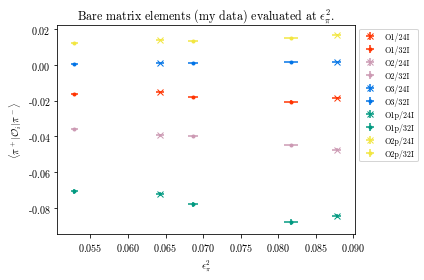

In [31]:
# Plot data points. This shouldn't match up with David's graph, that graph is plotting these points after subtracting the fit off
markers = ['v', 'v', '.', '.', '.']
plt.figure()
for i in range(n_ops):
#     plt.errorbar(eps_phys_mu[:2], [mat_elem_mu[j][i] for j in range(n_ens)][:2], xerr = eps_phys_sigma[:2], yerr = [mat_elem_sigma[j][i] for j in range(n_ens)][:2], fmt = 'x', c = colors[i], label = labels[i] + '/24I')
#     plt.errorbar(eps_phys_mu[2:], [mat_elem_mu[j][i] for j in range(n_ens)][2:], xerr = eps_phys_sigma[2:], yerr = [mat_elem_sigma[j][i] for j in range(n_ens)][2:], fmt = '.', c = colors[i], label = labels[i] + '/32I')
    plt.errorbar(eps_mu[:2], [mat_elem_mu[j][i] for j in range(n_ens)][:2], xerr = eps_phys_sigma[:2], yerr = [mat_elem_sigma[j][i] for j in range(n_ens)][:2], fmt = 'x', c = colors[i], label = labels[i] + '/24I')
    plt.errorbar(eps_mu[2:], [mat_elem_mu[j][i] for j in range(n_ens)][2:], xerr = eps_phys_sigma[2:], yerr = [mat_elem_sigma[j][i] for j in range(n_ens)][2:], fmt = '.', c = colors[i], label = labels[i] + '/32I')
plt.xlabel('$\epsilon_\pi^2$')
plt.ylabel('$\\langle \pi^+ | \mathcal{O}_i | \pi^- \\rangle$')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 8})
# plt.xlim((0.025, 0.045))
# plt.ylim((0.015, 0.029))
# plt.title('Renormalized matrix elements evaluated at $\epsilon_\pi^2|_{f_0}$.')

# plt.vlines(eps_sq_0, -0.08, 0.02, linestyles = 'dashed', label = '$\epsilon^2_{\mathrm{PDG}}$')
# plt.errorbar([eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0], O_phys_mu, yerr = O_phys_sigma, c = 'k', fmt = 'o')

plt.title('Bare matrix elements (my data) evaluated at $\epsilon_\pi^2$.')
plt.tight_layout()
plt.show()

## Perform the fit

In [24]:
def f0(m, L, ainv):
    f0 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f0 += -2 * kn(0, (m / ainv) * L * n)
    return f0
def f1(m, L, ainv):
    f1 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f1 += 4 * kn(1, (m / ainv) * L * n) / ((m / ainv) * L * n)
    return f1
# for O1, O2, O1p, O2p, fv = -f0 + 2*f1, for O3 fv = f0 + 2*f1
def get_fv_fn(op_idx):
    if op_idx == 2:    # for O3
        return lambda m, L, ainv : f0(m, L, ainv) + 2 * f1(m, L, ainv)
    return lambda m, L, ainv : -f0(m, L, ainv) + 2 * f1(m, L, ainv)

In [25]:
# Define functional fit forms for the operators
def O1(a1, b1, c1, m, f, a_sq, fv):    # a_lat should be in GeV^-1, 
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m ** 2) / Lam_sq
    return b1*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c1 + fv) + a1 * a_sq)
def O2(a2, b2, c2, m, f, a_sq, fv):
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m**2) / Lam_sq
    return b2*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c2 + fv) + a2 * a_sq)
def O3(a3, b3, c3, m, f, a_sq, fv):
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m**2) / Lam_sq
    return e_sq * b3*Lam_sq**2/(16*np.pi**2) * (1 - e_sq*(3*np.log(e_sq) + 1 - c3 + fv) + a3 * a_sq)
def get_chi2(O_fn):
    def chi2(x, m, f, a_sq, fv, O_val, dO):    # x should be (alpha, beta, c), the fit params to get
        val = 0.0
        for j in range(n_ens):
            val += (O_fn(x[0], x[1], x[2], m[j], f[j], a_sq[j], fv[j]) - O_val[j]) ** 2 / (dO[j] ** 2)
        return val
    return chi2
O_list = [O1, O2, O3, O1, O2]
chi2_list = [get_chi2(Oi) for Oi in O_list]

#### Fit to mean

For a given operator $\mathcal O^k$, this should be changed to a correlated fit between $(m_\pi, f_\pi, \mathcal O^k)$ on each ensemble. The covariance matrix will be 15 x 15 ($n_{ens}$ times len($(m_\pi, f_\pi, \mathcal O^k)$)) block-diagonal matrix, where each block is $3\times 3$. 

In [26]:
# construct guesses for solution
# TODO: get guesses by fitting to mean values. Right now I just copied david's values over
n_fit_params = 3
guesses0 = np.array([
    [-1.3, -1.7, -0.8], 
    [10.3, -5.0, -1.1], 
    [51.4, 0.6, 1.7], 
    [-1.5, -5.5, -1.1], 
    [7.7, 1.3, -1.1]
], dtype = np.float64)
guesses1 = np.zeros((n_ops, n_fit_params), dtype = np.float64)
# fit mean values to get guesses1
for op_idx in range(n_ops):
    print(op_idx)
    fv = get_fv_fn(op_idx)
    fv_list = np.array([fv(mpi_mu[ens_idx], L_cfgs[ens_idx], ainv_ens_mu[ens_idx]) for ens_idx in range(n_ens)])
    O_elems = np.array([mat_elem_mu[ens_idx][op_idx] for ens_idx in range(n_ens)], dtype = np.float64)
    O_elems_sigma = np.array([mat_elem_sigma[ens_idx][op_idx] for ens_idx in range(n_ens)], dtype = np.float64)
    out = optimize.minimize(chi2_list[op_idx], guesses0[op_idx], args = (mpi_mu, fpi_mu, asq_ens_mu, \
            fv_list, O_elems, O_elems_sigma), method = 'Powell', options = {'maxiter':10000, 'ftol':1.0e-08})
    guesses1[op_idx, :] = out['x'][:]

0
1
2
3
4


In [27]:
# the difference in fits to mean each time I run them is due to uncertainty in the lattice spacing, since I haven't 
# seeded the random number generator for the fake ensembles
print('Results of fits to mean:')
print('α | β | c')
for i in range(n_ens):
    print(labels[i])
    print(guesses1[i])

Results of fits to mean:
α | β | c
O1
[-9.52758845 -1.40161263 -0.38736737]
O2
[ 6.38575809 -2.76037787 -1.04418608]
O3
[3.02810427 0.46188772 0.16312689]
O1p
[-2.81603477 -6.00856217 -1.04282546]
O2p
[13.40489197  0.76280277 -1.42604043]


#### Fit to full data

In [50]:
alpha = [Superboot(n_ens) for i in range(n_ops)]
beta = [Superboot(n_ens) for i in range(n_ops)]
c = [Superboot(n_ens) for i in range(n_ops)]
# store the matrix elements after subtraction here. phys == actual results subtracted back to the physical point, 
# subtracted == extrapolated results to physical decay constant and lattice spacing at different pion masses. 
# plot eps_sq_subtracted vs mat_elems_subtracted.
mat_elems_phys = [Superboot(n_ens) for j in range(n_ops)]    # extrapolate to the physical pion mass
mat_elems_subtracted = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]
chi2_boots = [Superboot(n_ens) for i in range(n_ops)]
chi2_ndof_boots = [Superboot(n_ens) for i in range(n_ops)]
m_range = np.linspace(0.0, 0.5, 101)    # range of m's to plot chiral extrapolation band at
band_data = [[Superboot(n_ens) for j in range(n_ops)] for i in range(len(m_range) - 1)]
for op_idx in range(n_ops):
    print('Operator ' + labels[op_idx])
    fv = get_fv_fn(op_idx)
    guess = guesses1[op_idx]
    O_sigma = np.array([mat_elem_sigma[i][op_idx] for i in range(n_ens)])    # uncertainty doesn't change per boot idx
    for ens_idx in range(n_ens):
        for b_idx in range(n_samples[ens_idx]):
            print('Ensemble ' + str(ens_idx) + ', boot ' + str(b_idx))
            m_boot = np.array([mpi_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            f_boot = np.array([fpi_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            ainv_boot = np.array([ainv_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            asq_boot = np.array([asq_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            fv_boot = np.array([fv(m_boot[i], L_cfgs[i], ainv_boot[i]) for i in range(n_ens)])
            O_boot = np.array([mat_elems_ens[i][op_idx].boots[ens_idx, b_idx] for i in range(n_ens)])
            out = optimize.minimize(chi2_list[op_idx], guess, args = (m_boot, f_boot, asq_boot, fv_boot, O_boot, \
                                        O_sigma), method = 'Powell', options = {'maxiter' : 10000, 'ftol' : 1.0e-08})
            alphab, betab, cb = out['x']
            print(alphab, betab, cb)
            alpha[op_idx].boots[ens_idx, b_idx] = alphab
            beta[op_idx].boots[ens_idx, b_idx] = betab
            c[op_idx].boots[ens_idx, b_idx] = cb
            chi2_boots[op_idx].boots[ens_idx, b_idx] = out.fun
            chi2_ndof_boots[op_idx].boots[ens_idx, b_idx] = out.fun / (n_ens - 3.0)   # 5 - 3, for 3 fit params
            # subtract off extrapolation @ phys point to get extrapolated matrix element
            mat_elems_phys[op_idx].boots[ens_idx, b_idx] = O_list[op_idx](alphab, betab, cb, mpi_0_ens.boots[ens_idx, b_idx], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)
            
            # subtract off artifacts and extrapolate everything but the pion mass away-- these are the plotted points
            for i in range(n_ens):
                mat_elems_subtracted[i][op_idx].boots[ens_idx, b_idx] = O_boot[i] \
                    - O_list[op_idx](alphab, betab, cb, m_boot[i], f_boot[i], asq_boot[i], fv_boot[i]) \
                    + O_list[op_idx](alphab, betab, cb, m_boot[i], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)
            for m in range(len(m_range) - 1):    # extrapolate to value m for the pion mass
                band_data[m][op_idx].boots[ens_idx, b_idx] = \
                    O_list[op_idx](alphab, betab, cb, m_range[m + 1], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)

Operator O1
Ensemble 0, boot 0
-9.537623660850238 -1.3975853926033701 -0.4313812177055083
Ensemble 0, boot 1
-9.656993683392056 -1.4141195186198103 -0.4046937972663027
Ensemble 0, boot 2
-9.913799005631278 -1.4287982375554904 -0.5402525344919384
Ensemble 0, boot 3
-9.844765053741673 -1.4320838937597309 -0.4272437438836988
Ensemble 0, boot 4
-9.514294892053272 -1.401127152655397 -0.3769049757947623
Ensemble 0, boot 5
-10.039244700898559 -1.4319407468853689 -0.618256957971695
Ensemble 0, boot 6
-10.295395233016704 -1.4483731255093817 -0.7127134367424784
Ensemble 0, boot 7
-9.491484700739933 -1.403175158189433 -0.3296632000838118
Ensemble 0, boot 8
-9.645440014513742 -1.411979046048767 -0.4097107216034579
Ensemble 0, boot 9
-10.609344172634074 -1.4818060770905344 -0.7766667018642514
Ensemble 0, boot 10
-9.848023009172667 -1.4342128502216624 -0.4077633978470633
Ensemble 0, boot 11
-9.100187095124307 -1.3668058373193708 -0.286755484891018
Ensemble 0, boot 12
-9.39716383559198 -1.39028507264

-9.810141939723039 -1.4029840719848639 -0.3449048689094141
Ensemble 2, boot 5
-9.47805124793248 -1.4018783243274202 -0.3954194517429435
Ensemble 2, boot 6
-9.807087754124874 -1.3970820260520724 -0.3391179541135909
Ensemble 2, boot 7
-9.206607434254588 -1.3896755767609101 -0.4256447212697305
Ensemble 2, boot 8
-12.397828534422434 -1.416192612054193 0.05655890032781322
Ensemble 2, boot 9
-8.268005000624573 -1.3911887301075931 -0.5716436212394418
Ensemble 2, boot 10
-10.041313538639518 -1.3951666672007528 -0.29918512313809037
Ensemble 2, boot 11
-9.83790552161285 -1.4065338193922892 -0.343772070602878
Ensemble 2, boot 12
-10.553418297842363 -1.4076738577264687 -0.23308435312979298
Ensemble 2, boot 13
-9.040506924079745 -1.3959310055253105 -0.4573302294788429
Ensemble 2, boot 14
-10.642471455298086 -1.403849743539021 -0.21341454922230896
Ensemble 2, boot 15
-5.156681207077102 -1.4046508243270577 -1.0721089548644036
Ensemble 2, boot 16
-6.901641616576216 -1.4040197759062967 -0.7971267486133

-9.821045388493822 -1.4440267595324872 -0.539076787352157
Ensemble 4, boot 9
-9.53274650967003 -1.403824709483205 -0.4168253068066477
Ensemble 4, boot 10
-9.911246699700486 -1.4564823830303983 -0.5717891211490205
Ensemble 4, boot 11
-9.661142176806885 -1.4209320029988717 -0.4639703086582703
Ensemble 4, boot 12
-9.393518597953893 -1.3811140307000094 -0.2696506472483856
Ensemble 4, boot 13
-9.244136649779628 -1.3583268952452738 -0.1967077723018278
Ensemble 4, boot 14
-9.015495282890154 -1.3306885711801228 -0.08656537330549023
Ensemble 4, boot 15
-9.358465134367693 -1.3763166291932774 -0.2623169396812512
Ensemble 4, boot 16
-10.170665034390062 -1.4982785658043685 -0.8021535529180059
Ensemble 4, boot 17
-9.80935290947006 -1.4400336074201467 -0.504090278017042
Ensemble 4, boot 18
-9.4463172672545 -1.394604044408141 -0.4322288427234728
Ensemble 4, boot 19
-9.869386191076059 -1.4490952661459746 -0.5315726146376191
Ensemble 4, boot 20
-9.664197876311954 -1.422702807183904 -0.4898659400736191
E

8.164217036453087 -2.7954336473520596 -1.3491938974542903
Ensemble 1, boot 15
6.90998924872253 -2.7727538753113903 -1.1364091137023316
Ensemble 1, boot 16
5.56931211555483 -2.756322220790749 -0.9144209781530971
Ensemble 1, boot 17
4.508842364106699 -2.739349769403743 -0.7325557940786429
Ensemble 1, boot 18
3.675385922335849 -2.7143426051633437 -0.5782629724518199
Ensemble 1, boot 19
6.314814490821003 -2.8143773803651677 -1.0864885596542857
Ensemble 1, boot 20
6.168774217785652 -2.793822974465038 -1.0435513644106746
Ensemble 1, boot 21
5.583653554240988 -2.752597353227265 -0.9129384077434936
Ensemble 1, boot 22
5.944863210798712 -2.722473013590502 -0.9384691504861216
Ensemble 1, boot 23
5.229389006485212 -2.7277981472275203 -0.8335428286720734
Ensemble 1, boot 24
5.807212299733614 -2.7323479476760077 -0.9272401851142574
Ensemble 1, boot 25
9.359227769663825 -2.8052003397518708 -1.5431961780420265
Ensemble 1, boot 26
6.06900574288485 -2.75955751295471 -0.9947952450151027
Ensemble 1, boot

7.214675447997901 -2.7128807903115764 -1.0692386685061552
Ensemble 3, boot 22
4.990432544086856 -2.7871941962934526 -0.9783882706996294
Ensemble 3, boot 23
7.1808276971562135 -2.7310717416726256 -1.0700861181608445
Ensemble 3, boot 24
6.73803607783101 -2.7525187130467716 -1.0561587514194095
Ensemble 3, boot 25
5.146336579614893 -2.7981607907152575 -0.9924029708402186
Ensemble 3, boot 26
5.223472082019425 -2.7967332945179324 -0.9868847628729513
Ensemble 3, boot 27
6.443488078569519 -2.742784465478881 -1.0448615380003514
Ensemble 3, boot 28
6.5732526583950985 -2.7542011782698874 -1.0512512860630565
Ensemble 3, boot 29
8.184493961430807 -2.680688274715475 -1.0933655892066418
Ensemble 3, boot 30
5.302076751237537 -2.811545531773293 -0.9991721957255433
Ensemble 3, boot 31
6.840076128780453 -2.7340083868842204 -1.0591210143107472
Ensemble 3, boot 32
6.513157933847183 -2.759772755704019 -1.0490282780605535
Ensemble 3, boot 33
7.305632308993148 -2.7367541812384153 -1.0715139570005063
Ensemble 

3.510737451685781 0.45725823595972526 0.334775839309675
Ensemble 0, boot 28
3.027513122240568 0.4615334591481657 0.11236166071445845
Ensemble 0, boot 29
2.800713501896401 0.46321629449454127 -0.060636574775276966
Ensemble 0, boot 30
3.7748870165820763 0.454996155091944 0.47686615545754063
Ensemble 0, boot 31
3.819645875076054 0.4533892174426259 0.30707820403916086
Ensemble 0, boot 32
1.9820657140268552 0.4719398452623442 -0.23424656915589126
Ensemble 0, boot 33
-0.4295155209772133 0.49601169650665256 -1.0722899820575467
Ensemble 0, boot 34
3.0351909747501455 0.46059243340979106 0.026273410507375406
Ensemble 0, boot 35
2.548043730250191 0.4665207743554174 -0.033536098427286956
Ensemble 0, boot 36
3.834144994027918 0.4539865562222528 0.41758401175921084
Ensemble 0, boot 37
3.084689189156979 0.4617436965042897 0.24456560577302744
Ensemble 0, boot 38
3.1314131224649895 0.4608917610366985 0.20647888741105508
Ensemble 0, boot 39
3.837368321987602 0.45391419619909096 0.4594518971995756
Ensemb

5.311976391140727 0.4663544045164981 -0.32991439264249206
Ensemble 2, boot 34
2.7994683216645058 0.4640066285350482 0.16517496159051262
Ensemble 2, boot 35
2.6044528145835253 0.4544567274706529 0.37902320185900706
Ensemble 2, boot 36
6.036840990334639 0.4571803620632412 -0.33049130109735797
Ensemble 2, boot 37
4.0668121248064555 0.4566166888122383 0.07015675938679033
Ensemble 2, boot 38
2.012531350565549 0.45482610316018673 0.4819557039199631
Ensemble 2, boot 39
4.4653575657794855 0.4617348127041985 -0.09665768623599283
Ensemble 2, boot 40
5.06632697922069 0.4671253042419198 -0.3102986904014992
Ensemble 2, boot 41
4.7068532530792515 0.4664220823304131 -0.22846405333893594
Ensemble 2, boot 42
3.058713103401853 0.466353973557465 0.07516622990070054
Ensemble 2, boot 43
0.8134205697308408 0.4627221059041345 0.5649899937996246
Ensemble 2, boot 44
-0.7253052774216232 0.459990194222411 0.9045987336090541
Ensemble 2, boot 45
3.120541163577614 0.45959702888294257 0.1916297844236737
Ensemble 2, 

2.9144820567311625 0.4664588262536083 -0.11924439497907863
Ensemble 4, boot 41
1.9711428076979547 0.48362976743966524 -0.5520297857250003
Ensemble 4, boot 42
2.987083707673167 0.4607080081563368 0.29638810492736506
Ensemble 4, boot 43
3.09866854108498 0.45746634719538104 0.5168477833425148
Ensemble 4, boot 44
1.9662671763152078 0.4826066975836986 -0.4799999936787157
Ensemble 4, boot 45
2.6074478839283204 0.4704506854380628 -0.14059436056093236
Ensemble 4, boot 46
3.7084188806581073 0.4483883699491729 0.6410284839016734
Ensemble 4, boot 47
3.2759873680055773 0.45900403631672465 0.17914489767670203
Ensemble 4, boot 48
3.9534088658277056 0.44379218656495245 0.8118242838737063
Ensemble 4, boot 49
4.151699967445636 0.4427427380471021 0.7708284368571634
Operator O1p
Ensemble 0, boot 0
-2.997824173768092 -6.019448503396739 -1.1117065045816412
Ensemble 0, boot 1
-2.8797788822854744 -6.039006091258003 -1.0321079899799215
Ensemble 0, boot 2
-3.132486859801942 -6.069739792355621 -1.11714220353464

1.1228476926791964 -6.15397066866779 -1.6857483648854266
Ensemble 1, boot 46
-1.0497688790179236 -6.1113555648304905 -1.3441654414152804
Ensemble 1, boot 47
-0.534150168979923 -6.088445576475753 -1.4158914510252019
Ensemble 1, boot 48
-3.8624334851725455 -5.955523680283605 -0.8651146014195679
Ensemble 1, boot 49
-1.4923587169223667 -6.037145441851561 -1.2544636146737451
Ensemble 2, boot 0
-2.142829081937101 -6.030306854110364 -1.1584340854822104
Ensemble 2, boot 1
-4.606950948841675 -5.946311517635241 -0.7273878685364235
Ensemble 2, boot 2
-3.386892364139427 -5.961841660862107 -0.9341257161268153
Ensemble 2, boot 3
-3.430342538119425 -6.0465954638264545 -0.9551469331729757
Ensemble 2, boot 4
-3.042461986126716 -6.013219954000124 -1.0080958081717286
Ensemble 2, boot 5
-2.5089801726572984 -6.011290974535231 -1.0934536240259298
Ensemble 2, boot 6
-3.0469300598508933 -5.987209594439514 -0.9981189029975218
Ensemble 2, boot 7
-2.7620843161026665 -5.957547530049661 -1.0352798066159634
Ensembl

-3.4564292796343015 -6.290033369326184 -1.2523270064200316
Ensemble 4, boot 1
-2.9118045145923204 -6.039652985078682 -1.0176758699514172
Ensemble 4, boot 2
-2.8853803048478084 -6.032886742417469 -1.040734170871879
Ensemble 4, boot 3
-3.2222728139803256 -6.184619326104392 -1.1553915286097116
Ensemble 4, boot 4
-2.604452356244176 -5.911334076106272 -0.9457417862655834
Ensemble 4, boot 5
-3.0953149444390506 -6.122103262166315 -1.0760431811321314
Ensemble 4, boot 6
-2.9131544898653634 -6.045884398493424 -1.04359871378596
Ensemble 4, boot 7
-2.65038702156014 -5.919284255033535 -0.9083146210547836
Ensemble 4, boot 8
-2.964278531106895 -6.070290373146511 -1.078068627722906
Ensemble 4, boot 9
-2.817152857211208 -6.013598828325758 -1.067423591850691
Ensemble 4, boot 10
-3.194011368788227 -6.173621089435899 -1.1572650158796367
Ensemble 4, boot 11
-2.973511632519276 -6.079167713476908 -1.1054609211183892
Ensemble 4, boot 12
-2.7749869433587078 -5.98663391943613 -0.9931964676332955
Ensemble 4, boo

15.246591692385755 0.7780157500578877 -1.7967095585410362
Ensemble 1, boot 7
13.924244987511967 0.7641048840817506 -1.5168088026994173
Ensemble 1, boot 8
11.881274959495537 0.7584147198605538 -1.1531220576885002
Ensemble 1, boot 9
12.176235387242544 0.7593107937894857 -1.2063943641349406
Ensemble 1, boot 10
12.714622224824291 0.7771467745790405 -1.3789889423682886
Ensemble 1, boot 11
14.378831634156995 0.7622546060788093 -1.583793737438563
Ensemble 1, boot 12
11.775634633587712 0.7498440856827526 -1.0940241671790647
Ensemble 1, boot 13
15.731067602883092 0.7825824081376513 -1.897621516367021
Ensemble 1, boot 14
15.362255926393047 0.7767619178541096 -1.8103005253082298
Ensemble 1, boot 15
13.90918663213396 0.7669721102846176 -1.5280199476748564
Ensemble 1, boot 16
12.386009444054359 0.759151610109338 -1.24030460741398
Ensemble 1, boot 17
11.38916265005529 0.7533682175070225 -1.0467326144933164
Ensemble 1, boot 18
10.255325811751426 0.7429397981624661 -0.807391272506434
Ensemble 1, boot 

12.763960084329982 0.7676062960526281 -1.3996731559050108
Ensemble 3, boot 14
16.164913787732385 0.7363179888475748 -1.5112766311634773
Ensemble 3, boot 15
12.490800196478215 0.7705798131408947 -1.3954415409174967
Ensemble 3, boot 16
14.646662504100883 0.7514474632139326 -1.4715677849859732
Ensemble 3, boot 17
12.715752716620733 0.7700789261421522 -1.4016189568942012
Ensemble 3, boot 18
12.361331044658355 0.7702498699465211 -1.3808266589928506
Ensemble 3, boot 19
14.124291784173549 0.7546767473155571 -1.4515259201455804
Ensemble 3, boot 20
14.16412894826839 0.7522719295796229 -1.4520258543176336
Ensemble 3, boot 21
14.394583345437665 0.7491941288906905 -1.4582715719645623
Ensemble 3, boot 22
11.617540530450437 0.7729211516576177 -1.341538818117147
Ensemble 3, boot 23
14.481354790907552 0.7529010130553729 -1.4641985291392323
Ensemble 3, boot 24
13.994364118100735 0.7587483783281609 -1.4479871747541335
Ensemble 3, boot 25
11.90078601750784 0.7747167867513364 -1.3615277916134625
Ensemble 

#### Print mean and std for bootstrapped fit parameters

In [51]:
# chi2_boots[0].compute_mean() / 2

In [52]:
alpha_mu = [alpha[i].compute_mean() for i in range(n_ops)]
alpha_sigma = [alpha[i].compute_std() for i in range(n_ops)]
beta_mu = [beta[i].compute_mean() for i in range(n_ops)]
beta_sigma = [beta[i].compute_std() for i in range(n_ops)]
c_mu = [c[i].compute_mean() for i in range(n_ops)]
c_sigma = [c[i].compute_std() for i in range(n_ops)]
for op_idx in range(n_ops):
    print('Fit parameters for operator ' + labels[op_idx])
    print('alpha = ' + str(alpha_mu[op_idx]) + ' \pm ' + str(alpha_sigma[op_idx]))
    print('beta = ' + str(beta_mu[op_idx]) + ' \pm ' + str(beta_sigma[op_idx]))
    print('c = ' + str(c_mu[op_idx]) + ' \pm ' + str(c_sigma[op_idx]))

Fit parameters for operator O1
alpha = -9.524072840001494 \pm 3.5383844882298443
beta = -1.401354825478329 \pm 0.08684388006873914
c = -0.3804697914704803 \pm 0.6409397823404606
Fit parameters for operator O2
alpha = 6.3962040093679375 \pm 3.1805083398263037
beta = -2.75981963591278 \pm 0.14390082556705389
c = -1.0388113656555729 \pm 0.5156096426561582
Fit parameters for operator O3
alpha = 3.0363364610044474 \pm 3.282679752840167
beta = 0.46189302688167677 \pm 0.018872461428853085
c = 0.16845285295397078 \pm 0.7878458354073368
Fit parameters for operator O1p
alpha = -2.8115131458047355 \pm 2.692413542940298
beta = -6.0074894718710965 \pm 0.2785072447079635
c = -1.038615976261689 \pm 0.45841651466080513
Fit parameters for operator O2p
alpha = 13.426274385770636 \pm 3.8482638961344118
beta = 0.7626440102159764 \pm 0.045952388034232405
c = -1.4199153696420277 \pm 0.5821766576354331


#### Get error on data and print subtracted matrix elements

In [53]:
print('Values of chirally extrapolated operators at physical point.')
O_phys_mu = [mat_elems_phys[i].compute_mean() for i in range(n_ops)]
O_phys_sigma = [mat_elems_phys[i].compute_std() for i in range(n_ops)]
for op_idx in range(n_ops):
    print('<pi|' + labels[op_idx] + '|pi> = ' + str(O_phys_mu[op_idx]) + ' \pm ' + str(O_phys_sigma[op_idx]))

Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.014699003872335534 \pm 0.0008065009655491072
<pi|O2|pi> = -0.02864793520011115 \pm 0.0013202803640260908
<pi|O3|pi> = 8.96823407542763e-05 \pm 2.931457515195778e-06
<pi|O1p|pi> = -0.06236085910276839 \pm 0.0025412264157185834
<pi|O2p|pi> = 0.007868278873557956 \pm 0.00042549395447554346


#### Plot values of the chiral extrapolation at different values of $m_{\pi}$

In [54]:
# callat_colors = ['limegreen', 'deepskyblue', 'r', 'g', 'midnightblue']    # use for comparison purposes
# colors = ['r', 'g', 'b', 'c', 'y']

In [55]:
epsilon_sq_range = m_range ** 2 / (8 * (np.pi ** 2) * (fpi_0_ens.avg) ** 2)
eps_sq_0 = mpi_0[0] ** 2 / (8 * (np.pi ** 2) * (fpi_0[0] ** 2))
# epsilon_sq_range = m_range ** 2 / (16 * (np.pi ** 2) * (fpi_0_ens.avg) ** 2)
# eps_sq_0 = mpi_0[0] ** 2 / (16 * (np.pi ** 2) * (fpi_0[0] ** 2))
eps_sq_subtracted = [Superboot(n_ens) for i in range(n_ens)]
for i in range(n_ens):
    for ens_idx in range(n_ens):
        for b_idx in range(n_boot):
#             eps_sq_subtracted[i].boots[ens_idx, b_idx] = mpi_ens[i].boots[ens_idx, b_idx] ** 2 / (16 * (np.pi**2) \
#                                                             * (fpi_0_ens.boots[ens_idx, b_idx] ** 2))
            eps_sq_subtracted[i].boots[ens_idx, b_idx] = mpi_ens[i].boots[ens_idx, b_idx] ** 2 / (8 * (np.pi**2) \
                                                            * (fpi_0_ens.boots[ens_idx, b_idx] ** 2))
eps_sq_sub_mu = [eps_sq_subtracted[i].compute_mean() for i in range(n_ens)]    # may want to make .avg instead
eps_sq_sub_sigma = [eps_sq_subtracted[i].compute_std() for i in range(n_ens)]
# get data points
mat_elems_sub_mu = [[mat_elems_subtracted[i][j].compute_mean() for i in range(n_ens)] for j in range(n_ops)]
mat_elems_sub_sigma = [[mat_elems_subtracted[i][j].compute_std() for i in range(n_ens)] for j in range(n_ops)]
# get band
# band_data_mu = [[band_data[i][j].compute_mean() for j in range(n_ops)] for i in range(len(m_range) - 1)]
# band_data_sigma = [[band_data[i][j].compute_std() for j in range(n_ops)] for i in range(len(m_range) - 1)]
band_data_mu = np.array([[band_data[i][j].compute_mean() for i in range(len(m_range) - 1)] for j in range(n_ops)])
band_data_sigma = np.array([[band_data[i][j].compute_std() for i in range(len(m_range) - 1)] for j in range(n_ops)])

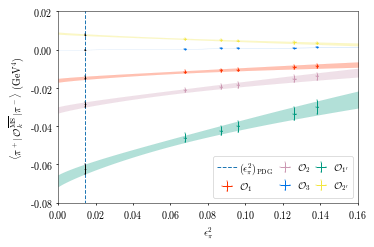

In [56]:
# plot the extrapolation
markers = ['o', 'v', '^', '_', 'x']
# style = styles['prd_twocol']
style = styles['prd_twocol*']
scale = 1        # scale factor to compare to CalLat if we want
labels = ['$\mathcal{O}_1$', '$\mathcal{O}_2$', '$\mathcal{O}_3$', '$\mathcal{O}_{1\'} $', '$\mathcal{O}_{2\'} $']
with sns.plotting_context('paper'):
    #plt.figure(figsize = (10, 6))
    #asp_ratio = 4/3
    asp_ratio = 3/2
    plt.figure(figsize = (0.75*style['colwidth'], 0.75*style['colwidth'] / asp_ratio))
    for j in range(n_ops):
        _, caps, _ = plt.errorbar(eps_sq_sub_mu, scale * np.array(mat_elems_sub_mu[j]), xerr = eps_sq_sub_sigma, yerr = mat_elems_sub_sigma[j], \
                     c = colors[j], fmt = markers[j], label = labels[j], capsize = style['endcaps'], elinewidth = style['ebar_width'], \
                     markersize = style['markersize'])
        plt.fill_between(epsilon_sq_range[1:], scale * np.array(band_data_mu[j]) + band_data_sigma[j], scale * np.array(band_data_mu[j]) - band_data_sigma[j], \
                        color = colors[j], alpha = 0.3, linewidth = 0.1)
        for cap in caps:
            cap.set_markeredgewidth(style['ecap_width'])
    plt.vlines(eps_sq_0, -0.1, 0.02, linestyles = 'dashed', label = '$(\epsilon^2_\pi)_{\mathrm{PDG}}$', linewidth = style['ebar_width'])
    _, caps, _ = plt.errorbar([eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0], scale * np.array(O_phys_mu), yerr = O_phys_sigma, \
                 c = 'k', fmt = markers[j], capsize = style['endcaps'], markersize = style['markersize'], elinewidth = style['ebar_width'])
    for cap in caps:
        cap.set_markeredgewidth(style['ecap_width'])
#     plt.legend(bbox_to_anchor=(1.0, 0.0), loc='lower right', prop={'size': style['fontsize'] * 0.9}, ncol = 3, handletextpad = 0.2, columnspacing = 1.0)
    plt.legend(bbox_to_anchor=(1.0, 0.0), loc='lower right', prop={'size': style['fontsize']}, ncol = 3, handletextpad = 0.2, columnspacing = 0.1)
    plt.xlim((0.0, 0.16))
    plt.ylim((-0.08, 0.02))
    #plt.ylim((-0.1, 0.02))
    plt.xticks(fontsize = style['fontsize'])
    plt.yticks(fontsize = style['fontsize'])
    plt.xlabel('$\epsilon_\pi^2$', fontsize = style['fontsize'])
    plt.ylabel('$\\langle \pi^+| \, \mathcal{O}_k^{\overline{\mathrm{MS}}} \, |\pi^- \\rangle$ (GeV$^4$)', fontsize = style['fontsize'])
    ax = plt.gca()
    ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
    ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
    for spine in spinedirs:
        ax.spines[spine].set_linewidth(style['axeswidth'])
    plt.tight_layout()
    plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/renorm_chiral_extrap.pdf', bbox_inches='tight')
    #plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/renorm_chiral_extrap_Rp.pdf', bbox_inches='tight')
    plt.show()

In [57]:
# format output table
out_col_labels = np.array(['\\rule{0cm}{0.4cm}Operator', '$\\alpha_k$ ($\\mathrm{fm}^{-2}$)', '$\\beta_k$', '$c_k$', \
            '$\\langle\\pi^+ |\\mathcal{O}_k | \\pi^-\\rangle$ ($\\mathrm{GeV}^4$)', '$\\chi^2 / \\mathrm{dof}$'])
out_hor_labels = np.array(['$' + label + '$' for label in latex_labels])
# out_hor_labels[0] = '\\rule{0cm}{0.4cm}' + out_hor_labels[0]
out_means = np.array([alpha_mu, beta_mu, c_mu, O_phys_mu]).T
out_sigma = np.array([alpha_sigma, beta_sigma, c_sigma, O_phys_sigma]).T
param_table = Table(out_means, is_entry = False, sigma = out_sigma)
chi2_ndof_means = np.array([chi2_ndof.compute_mean() for chi2_ndof in chi2_ndof_boots])
chi2_table = Table(chi2_ndof_means, is_entry = False)
full_table = param_table.insert_cols({4 : chi2_table})
print(export_vert_table_latex(full_table, out_col_labels, out_hor_labels, hline_idxs = [0], \
                              header = '\\begin{tabular}{ c | ccc | c | c } \\hline \\hline '))

\begin{tabular}{ c | ccc | c | c } \hline \hline \rule{0cm}{0.4cm}Operator & $\alpha_k$ ($\mathrm{fm}^{-2}$) & $\beta_k$ & $c_k$ & $\langle\pi^+ |\mathcal{O}_k | \pi^-\rangle$ ($\mathrm{GeV}^4$) & $\chi^2 / \mathrm{dof}$ \\  \hline $\mathcal{O}_1$ & -9.5(3.5) & -1.401(87) & -0.38(64) & -0.01470(81) & 0.27 \\ $\mathcal{O}_2$ & 6.4(3.2) & -2.76(14) & -1.04(52) & -0.0286(13) & 0.43 \\ $\mathcal{O}_3$ & 3.0(3.3) & 0.462(19) & 0.17(79) & 0.0000897(29) & 0.28 \\ $\mathcal{O}_{1'}$ & -2.8(2.7) & -6.01(28) & -1.04(46) & -0.0624(25) & 0.61 \\ $\mathcal{O}_{2'}$ & 13.4(3.8) & 0.763(46) & -1.42(58) & 0.00787(43) & 0.40 \\  \hline \hline \end{tabular} 


## Result of Will's code (use this for final results for the paper)

#### Resave the data in an easier format to use, it's an absolute mess right now

In [32]:
# get matrix elements
ampi_david = np.array([[0.24160, 0.00045], [0.19131, 0.00051], [0.17277, 0.00056], [0.15077, 0.00045], [0.12652, 0.00039]])
afpi_david = np.array([[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]])
bare_mat_elems = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
renorm_mat_elems = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
for k in range(n_ops):
    for i in range(n_ens):
        bare_mat_elems[k, i] = mat_elems_bare[i][k].boots[i]
        renorm_mat_elems[k, i] = mat_elems_ens[i][k].boots[i]

In [33]:
# get two point functions
mpi_boots_full = np.zeros((n_ens, n_boot), dtype = np.float64)
fpi_boots_full = np.zeros((n_ens, n_boot), dtype = np.float64)
for ens_idx, config in enumerate(ensembles):
    path2pt = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/'+config+'/twopt_out.h5'
    twopt_data = h5py.File(path2pt, 'r')
    ampi_boot = twopt_data['ampi'][()]
    afpi_boot = twopt_data['afpi'][()]
    twopt_data.close()
    ampi_boot_shift = shift_boots(spread_boots(ampi_boot, ampi_david[ens_idx][1]), ampi_david[ens_idx][0])
    afpi_boot_shift = shift_boots(spread_boots(afpi_boot, afpi_david[ens_idx][1]), afpi_david[ens_idx][0])
    ampi_bar, δampi = np.mean(ampi_boot_shift), np.std(ampi_boot_shift, ddof = 1)
    afpi_bar, δafpi = np.mean(afpi_boot_shift), np.std(afpi_boot_shift, ddof = 1)
    new_mpi_err = np.sqrt((δampi ** 2)*(ainv_list[ens_idx][0] ** 2) + (ampi_bar ** 2)*(ainv_list[ens_idx][1] ** 2))
    new_fpi_err = np.sqrt((δafpi ** 2)*(ainv_list[ens_idx][0] ** 2) + (afpi_bar ** 2)*(ainv_list[ens_idx][1] ** 2))
    ampi_boot_shift = ainv_list[ens_idx][0] * ampi_boot_shift
    afpi_boot_shift = ainv_list[ens_idx][0] * afpi_boot_shift
    mpi_spread = spread_boots(ampi_boot_shift, new_mpi_err)
    fpi_spread = spread_boots(afpi_boot_shift, new_fpi_err)
    mpi_boots_full[ens_idx] = mpi_spread
    fpi_boots_full[ens_idx] = fpi_spread

In [34]:
# write_out_file = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/chi_extrap_data_RBC_renorm.h5'
# fw = h5py.File(write_out_file, 'w')
# fw['bare_mat_elems'] = bare_mat_elems
# fw['renorm_mat_elems'] = renorm_mat_elems
# fw['mpi'] = mpi_boots_full
# fw['fpi'] = fpi_boots_full
# fw['ainv'] = np.array(ainv_list)
# fw.close()

#### Generate plot with Will's numbers

In [145]:
# Fit values + stds
lec_keys = ['alpha', 'beta', 'c']
matelems = [
    gv.gvar('-0.01477(97)'),
    gv.gvar('-0.0287(16)'),
    gv.gvar('0.0001005(33)'),
    gv.gvar('-0.0625(33)'),
    gv.gvar('0.00786(52)')
]
# lec_results = [
#     {'alpha': '-0.34(17)', 'beta': '-1.41(11)', 'c': '-0.50(78)'}, 
#     {'alpha': '0.27(16)', 'beta': '-2.77(19)', 'c': '-1.11(69)'}, 
#     {'alpha': '0.08(11)', 'beta': '0.702(37)','c': '8.70(70)'}, 
#     {'alpha': '-0.092(79)', 'beta': '-6.07(22)','c': '-1.15(35)'}, 
#     {'alpha': '0.54(11)', 'beta': '0.768(36)','c': '-1.51(46)'}
# ]
lec_results = [
    {'alpha': '-0.34(17)', 'beta': '-1.41(11)', 'c': '-0.50(78)'}, 
    {'alpha': '0.27(16)', 'beta': '-2.77(19)', 'c': '-1.11(69)'}, 
    {'alpha': '0.063(88)', 'beta': '0.700(28)','c': '8.80(57)'}, 
    {'alpha': '-0.09(14)', 'beta': '-6.04(38)','c': '-1.12(63)'},
    {'alpha': '0.54(19)', 'beta': '0.763(60)','c': '-1.46(76)'}
]
mpi_fit_str = [
    ['0.4311(15)', '0.3413(12)', '0.4112(23)', '0.3589(12)', '0.3017(14)'],
    ['0.4311(15)', '0.3413(12)', '0.4113(24)', '0.3589(13)', '0.3017(15)'],
    ['0.4308(16)', '0.3414(13)', '0.4109(25)', '0.3589(17)', '0.3010(17)'],
    ['0.4311(15)', '0.3413(12)', '0.4112(24)', '0.3589(13)', '0.3017(15)'], 
    ['0.4311(15)', '0.3413(12)', '0.4113(23)', '0.3589(13)', '0.3017(15)']
]
fpi_fit_str = [
    ['0.16363(70)', '0.15165(70)', '0.16206(95)', '0.15432(70)', '0.14756(95)'],
    ['0.16361(68)', '0.15166(68)', '0.16203(89)', '0.15438(63)', '0.14749(86)'],
    ['0.16363(73)', '0.15175(71)', '0.1621(10)', '0.15421(76)', '0.14769(99)'],
    ['0.16357(68)', '0.15170(68)', '0.16208(88)', '0.15437(64)', '0.14746(87)'],
    ['0.16361(68)', '0.15167(69)', '0.16205(91)', '0.15436(65)', '0.14749(89)']
]
a2_fit_str = [
    ['0.3142(18)', '0.3142(18)', '0.1762(12)', '0.1762(12)', '0.1762(12)'], 
    ['0.3142(18)', '0.3142(18)', '0.1762(12)', '0.1762(12)', '0.1762(12)'],
    ['0.3142(18)', '0.3142(18)', '0.1762(12)', '0.1763(12)', '0.1762(12)'],
    ['0.3142(18)', '0.3142(18)', '0.1762(12)', '0.1762(12)', '0.1762(12)'],
    ['0.3142(18)', '0.3142(18)', '0.1762(12)', '0.1762(12)', '0.1762(12)']
]

# mpi_fit = np.zeros((n_ops, n_ens), dtype = object)
# fpi_fit = np.zeros((n_ops, n_ens), dtype = object)
# a2_fit = np.zeros((n_ops, n_ens), dtype = object)
# for k in range(n_ops):
#     for ii in range(n_ens):
#         mpi_fit[k, ii] = gv.gvar(mpi_fit_str[k][ii])
#         fpi_fit[k, ii] = gv.gvar(fpi_fit_str[k][ii])
#         a2_fit[k, ii] = gv.gvar(a2_fit_str[k][ii])

In [157]:
# get correlations
from will_data_chiextrap import *
# all_gvars = np.zeros((n_ops, 18), dtype = object)
posteriors = []
for k in range(n_ops):
    gvar_strs = {
        'mpi' : mpi_fit_str[k],
        'fpi' : fpi_fit_str[k],
        'a2' : a2_fit_str[k]
    }
    gvar_strs.update(lec_results[k])
    print(gvar_strs)
    tmp = gv.gvar(gvar_strs)
    posteriors.append(gv.correlate(tmp, all_cov[k]))

{'mpi': ['0.4311(15)', '0.3413(12)', '0.4112(23)', '0.3589(12)', '0.3017(14)'], 'fpi': ['0.16363(70)', '0.15165(70)', '0.16206(95)', '0.15432(70)', '0.14756(95)'], 'a2': ['0.3142(18)', '0.3142(18)', '0.1762(12)', '0.1762(12)', '0.1762(12)'], 'alpha': '-0.34(17)', 'beta': '-1.41(11)', 'c': '-0.50(78)'}
{'mpi': ['0.4311(15)', '0.3413(12)', '0.4113(24)', '0.3589(13)', '0.3017(15)'], 'fpi': ['0.16361(68)', '0.15166(68)', '0.16203(89)', '0.15438(63)', '0.14749(86)'], 'a2': ['0.3142(18)', '0.3142(18)', '0.1762(12)', '0.1762(12)', '0.1762(12)'], 'alpha': '0.27(16)', 'beta': '-2.77(19)', 'c': '-1.11(69)'}
{'mpi': ['0.4308(16)', '0.3414(13)', '0.4109(25)', '0.3589(17)', '0.3010(17)'], 'fpi': ['0.16363(73)', '0.15175(71)', '0.1621(10)', '0.15421(76)', '0.14769(99)'], 'a2': ['0.3142(18)', '0.3142(18)', '0.1762(12)', '0.1763(12)', '0.1762(12)'], 'alpha': '0.063(88)', 'beta': '0.700(28)', 'c': '8.80(57)'}
{'mpi': ['0.4311(15)', '0.3413(12)', '0.4112(24)', '0.3589(13)', '0.3017(15)'], 'fpi': ['0.163

In [160]:
#####################################################################################
# need to generate:
#    mat_elems_sub_mu, mat_elems_sub_sigma
#    band_data_mu, band_data_sigma. This is just the result of F_k(...), where F_k is the model for O_k
#    (possibly) eps_sq_sub_mu, eps_sq_sub_sigma
#####################################################################################
m_range = np.linspace(0.0, 0.5, 101)    # range of m's to plot chiral extrapolation band at
epsilon_sq_range = m_range ** 2 / (8 * (np.pi ** 2) * (fpi_0_gvar.mean) ** 2)
eps_sq_0 = mpi_0[0] ** 2 / (8 * (np.pi ** 2) * (fpi_0[0] ** 2))
O_phys_mu = [matelems[k].mean for k in range(n_ops)]
O_phys_sigma = [matelems[k].sdev for k in range(n_ops)]
mpi_0_gvar = gv.gvar(mpi_0[0], mpi_0[1])
# TODO do we need to add correlation between fpi0 and the LECs?
fpi_0_gvar = gv.gvar(fpi_0[0], fpi_0[1])
band_data_mu = np.zeros((n_ops, len(m_range) - 1), dtype = np.float64)
band_data_sigma = np.zeros((n_ops, len(m_range) - 1), dtype = np.float64)
eps_sq_sub_mu = np.zeros((n_ens), dtype = np.float64)
eps_sq_sub_sigma = np.zeros((n_ens), dtype = np.float64)
mat_elems_sub_mu = np.zeros((n_ops, n_ens), dtype = np.float64)
mat_elems_sub_sigma = np.zeros((n_ops, n_ens), dtype = np.float64)
for ii in range(n_ens):
    eps_sq_sub = (mpi_gvar[ii]**2) / (8*(np.pi**2)*(fpi_0_gvar**2))
    eps_sq_sub_mu[ii] = eps_sq_sub.mean
    eps_sq_sub_sigma[ii] = eps_sq_sub.sdev
#     for k in range(n_ops):
#         mat_elems_sub = renorm_mats[k, ii] \
#             - O_list[k](lecs[k]['alpha'], lecs[k]['beta'], lecs[k]['c'], mpi_gvar[ii], fpi_gvar[ii], asq_gvar[ii], fv_gvar[ii]) \
#             + O_list[k](lecs[k]['alpha'], lecs[k]['beta'], lecs[k]['c'], mpi_gvar[ii], fpi_0_gvar, 0.0, 0.0)
#         mat_elems_sub_mu[k, ii] = mat_elems_sub.mean
#         mat_elems_sub_sigma[k, ii] = mat_elems_sub.sdev
for k in range(n_ops):
    for im, mm in enumerate(m_range[1:]):
        extrap_pt = O_list[k](posteriors[k]['alpha'], posteriors[k]['beta'], posteriors[k]['c'], mm, fpi_0_gvar, 0.0, 0.0)
        band_data_mu[k, im] = extrap_pt.mean
        band_data_sigma[k, im] = extrap_pt.sdev

I'm still doing something a bit wrong. We have:
$$
    F_k(m, f, a, L; \alpha_k, \beta_k, c_k) = \frac{\beta_1\Lambda_\chi^4}{(4\pi)^2} \bigg[1 + \epsilon_\pi^2 (\log \epsilon_\pi^2 - 1
    	 + c_1 -  f_0(m_\pi L) + 2 f_1 (m_\pi L)) + \alpha_1 a^2\bigg]
$$
The $\chi^2$ we're minimizing is with an 18-dimensional vector $m_\pi^{(i)}$, and corresponding extra data for $f$ and $a$. How do we incorporate this into the extrapolation?

In [125]:
# mpi_gvar = np.array([gv.gvar(np.mean(mpi_boots_full[ii]), np.std(mpi_boots_full[ii], ddof=1)) for ii in range(n_ens)])
# fpi_gvar = np.array([gv.gvar(np.mean(fpi_boots_full[ii]), np.std(fpi_boots_full[ii], ddof=1)) for ii in range(n_ens)])
# ainv_gvar = np.array([gv.gvar(ainv_list[ii][0], ainv_list[ii][1]) for ii in range(n_ens)])

# lec_cov = [
#     {('alpha', 'alpha'): np.array([[0.01542008]]),('alpha', 'beta'): np.array([[0.00132009]]),('alpha', 'c'): np.array([[-0.04613922]]),('beta', 'alpha'): np.array([[0.00132009]]),('beta', 'beta'): np.array([[0.00659339]]),('beta', 'c'): np.array([[0.03047125]]),('c', 'alpha'): np.array([[-0.04613922]]),('c', 'beta'): np.array([[0.03047125]]), ('c', 'c'): np.array([[0.33126096]])}, 
#     {('alpha', 'alpha'): np.array([[0.00797552]]),('alpha', 'beta'): np.array([[0.00246987]]),('alpha', 'c'): np.array([[-0.0180975]]),('beta', 'alpha'): np.array([[0.00246987]]),('beta', 'beta'): np.array([[0.01092484]]),('beta', 'c'): np.array([[0.02747109]]),('c', 'alpha'): np.array([[-0.0180975]]),('c', 'beta'): np.array([[0.02747109]]),('c', 'c'): np.array([[0.1536947]])}, 
#     {('alpha', 'alpha'): np.array([[0.01144851]]),('alpha', 'beta'): np.array([[-0.00128047]]),('alpha', 'c'): np.array([[-0.01394776]]),('beta', 'alpha'): np.array([[-0.00128047]]),('beta', 'beta'): np.array([[0.00133943]]),('beta', 'c'): np.array([[-0.02184198]]),('c', 'alpha'): np.array([[-0.01394776]]),('c', 'beta'): np.array([[-0.02184198]]),('c', 'c'): np.array([[0.48371344]])}, 
#     {('alpha', 'alpha'): np.array([[0.00619445]]),('alpha', 'beta'): np.array([[0.00365426]]),('alpha', 'c'): np.array([[-0.01613314]]),('beta', 'alpha'): np.array([[0.00365426]]),('beta', 'beta'): np.array([[0.04686797]]),('beta', 'c'): np.array([[0.04833786]]),('c', 'alpha'): np.array([[-0.01613314]]),('c', 'beta'): np.array([[0.04833786]]),('c', 'c'): np.array([[0.12115525]])}, 
#     {('alpha', 'alpha'): np.array([[0.01308675]]),('alpha', 'beta'): np.array([[-0.0017533]]),('alpha', 'c'): np.array([[-0.02224919]]),('beta', 'alpha'): np.array([[-0.0017533]]),('beta', 'beta'): np.array([[0.00131214]]),('beta', 'c'): np.array([[-0.01052607]]),('c', 'alpha'): np.array([[-0.02224919]]),('c', 'beta'): np.array([[-0.01052607]]),('c', 'c'): np.array([[0.21456447]])}
# ]
# lecs = [0, 0, 0, 0, 0]
# renorm_mats = np.zeros((n_ops, n_ens), dtype = object)
# fv_gvar = np.zeros((n_ens), dtype = object)
# # f0_gvars = [gv.gvar(fpi_0[0], fpi_0[1]) for ii in range(n_ens)]
# for k in range(n_ops):
#     tmp = gv.gvar(lec_results[k])
#     #lecs[k] = gv.correlate(tmp, lec_cov[k])
#     lecs[k] = tmp
# for ii in range(n_ens):
#     print('Initializing ensemble ' + str(ii))
#     mat_elems_ii = np.zeros((n_ops), dtype = object)
#     for k in range(n_ops):
#         mat_elems_ii[k] = gv.gvar(np.mean(renorm_mat_elems[k, ii]), np.std(renorm_mat_elems[k, ii], ddof = 1))
#     fv_b = np.zeros((n_boot), dtype = np.float64)
#     for b in range(n_boot):
#         fv_b[b] = fv(mpi_boots_full[ii, b], L_cfgs[ii], ainv_dist[ii, b])
#     fv_gvar[ii] = gv.gvar(np.mean(fv_b), np.std(fv_b, ddof = 1))
#     all_gvars = np.array([mpi_gvar[ii], fpi_gvar[ii], fv_gvar[ii], ainv_gvar[ii]], dtype = object)
#     all_gvars = np.append(all_gvars, mat_elems_ii)
#     all_boots = np.vstack([mpi_boots_full[ii], fpi_boots_full[ii], fv_b, ainv_dist[ii], renorm_mat_elems[0, ii], \
#                   renorm_mat_elems[1, ii], renorm_mat_elems[2, ii], renorm_mat_elems[3, ii], renorm_mat_elems[4, ii]])
#     covar = np.cov(all_boots)
#     #tmp = gv.correlate(all_gvars, covar)
#     tmp = all_gvars
#     mpi_gvar[ii] = tmp[0]
#     fpi_gvar[ii] = tmp[1]
#     fv_gvar[ii] = tmp[2]
#     ainv_gvar[ii] = tmp[3]
#     renorm_mats[:, ii] = tmp[4:]
#     print(tmp)

# asq_gvar = np.array([hbarc**2 / ainv_gvar[ii]**2 for ii in range(n_ens)], dtype = object)


Initializing ensemble 0
[0.4310(15) 0.16372(64) 0.01743(52) 1.7840(50) -0.02181(55) -0.05366(81)
 0.001845(24) -0.0975(14) 0.01595(26)]
Initializing ensemble 1
[0.3413(13) 0.15155(62) 0.0761(25) 1.7840(50) -0.01823(47) -0.04472(78)
 0.000935(14) -0.0834(12) 0.01335(25)]
Initializing ensemble 2
[0.4115(19) 0.16202(90) 0.02390(81) 2.3820(80) -0.02362(76) -0.05065(95)
 0.001603(26) -0.1003(18) 0.01437(35)]
Initializing ensemble 3
[0.3591(16) 0.15428(70) 0.0570(20) 2.3820(80) -0.02076(68) -0.04492(88)
 0.001083(18) -0.0891(16) 0.01279(32)]
Initializing ensemble 4
[0.3014(14) 0.14754(81) 0.1549(45) 2.3820(80) -0.01862(62) -0.04051(80)
 0.000656(11) -0.0809(15) 0.01156(29)]


In [162]:
renorm_mats

array([[-0.02181(55), -0.01823(47), -0.02362(76), -0.02076(68),
        -0.01862(62)],
       [-0.05366(81), -0.04472(78), -0.05065(95), -0.04492(88),
        -0.04051(80)],
       [0.001845(24), 0.000935(14), 0.001603(26), 0.001083(18),
        0.000656(11)],
       [-0.0975(14), -0.0834(12), -0.1003(18), -0.0891(16), -0.0809(15)],
       [0.01595(26), 0.01335(25), 0.01437(35), 0.01279(32), 0.01156(29)]],
      dtype=object)

In [127]:
# #####################################################################################
# # need to generate:
# #    mat_elems_sub_mu, mat_elems_sub_sigma
# #    band_data_mu, band_data_sigma. This is just the result of F_k(...), where F_k is the model for O_k
# #    (possibly) eps_sq_sub_mu, eps_sq_sub_sigma
# #####################################################################################
# m_range = np.linspace(0.0, 0.5, 101)    # range of m's to plot chiral extrapolation band at
# epsilon_sq_range = m_range ** 2 / (8 * (np.pi ** 2) * (fpi_0_gvar.mean) ** 2)
# eps_sq_0 = mpi_0[0] ** 2 / (8 * (np.pi ** 2) * (fpi_0[0] ** 2))
# O_phys_mu = [matelems[k].mean for k in range(n_ops)]
# O_phys_sigma = [matelems[k].sdev for k in range(n_ops)]
# mpi_0_gvar = gv.gvar(mpi_0[0], mpi_0[1])
# # TODO do we need to add correlation between fpi0 and the LECs?
# fpi_0_gvar = gv.gvar(fpi_0[0], fpi_0[1])
# band_data_mu = np.zeros((n_ops, len(m_range) - 1), dtype = np.float64)
# band_data_sigma = np.zeros((n_ops, len(m_range) - 1), dtype = np.float64)
# eps_sq_sub_mu = np.zeros((n_ens), dtype = np.float64)
# eps_sq_sub_sigma = np.zeros((n_ens), dtype = np.float64)
# mat_elems_sub_mu = np.zeros((n_ops, n_ens), dtype = np.float64)
# mat_elems_sub_sigma = np.zeros((n_ops, n_ens), dtype = np.float64)
# for ii in range(n_ens):
#     eps_sq_sub = (mpi_gvar[ii]**2) / (8*(np.pi**2)*(fpi_0_gvar**2))
#     eps_sq_sub_mu[ii] = eps_sq_sub.mean
#     eps_sq_sub_sigma[ii] = eps_sq_sub.sdev
#     for k in range(n_ops):
#         mat_elems_sub = renorm_mats[k, ii] \
#             - O_list[k](lecs[k]['alpha'], lecs[k]['beta'], lecs[k]['c'], mpi_gvar[ii], fpi_gvar[ii], asq_gvar[ii], fv_gvar[ii]) \
#             + O_list[k](lecs[k]['alpha'], lecs[k]['beta'], lecs[k]['c'], mpi_gvar[ii], fpi_0_gvar, 0.0, 0.0)
#         mat_elems_sub_mu[k, ii] = mat_elems_sub.mean
#         mat_elems_sub_sigma[k, ii] = mat_elems_sub.sdev
# for k in range(n_ops):
#     for im, mm in enumerate(m_range[1:]):
#         extrap_pt = O_list[k](lecs[k]['alpha'], lecs[k]['beta'], lecs[k]['c'], mm, fpi_0_gvar, 0.0, 0.0)
#         band_data_mu[k, im] = extrap_pt.mean
#         band_data_sigma[k, im] = extrap_pt.sdev

In [163]:
# have to figure out why the stds are so low on mine
for k in range(n_ops):
    print('k = ' + str(k))
    #print(O_list[k](lecs[k]['alpha'], lecs[k]['beta'], lecs[k]['c'], mpi_0_gvar, fpi_0_gvar, 0.0, 0.0))
    print(O_list[k](posteriors[k]['alpha'], posteriors[k]['beta'], posteriors[k]['c'], mpi_0_gvar, fpi_0_gvar, 0.0, 0.0))
    print(matelems[k])

k = 0
-0.01476(14)
-0.01477(97)
k = 1
-0.02872(34)
-0.0287(16)
k = 2
0.00015043(55)
0.0001005(33)
k = 3
-0.0626(13)
-0.0625(33)
k = 4
0.007866(76)
0.00786(52)


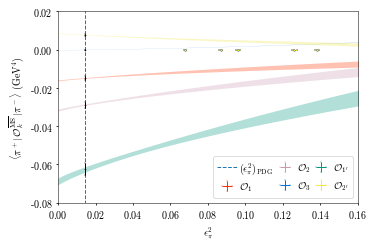

In [161]:
# plot the extrapolation
markers = ['o', 'v', '^', '_', 'x']
style = styles['prd_twocol*']
labels = ['$\mathcal{O}_1$', '$\mathcal{O}_2$', '$\mathcal{O}_3$', '$\mathcal{O}_{1\'} $', '$\mathcal{O}_{2\'} $']
with sns.plotting_context('paper'):
    asp_ratio = 3/2
    plt.figure(figsize = (0.75*style['colwidth'], 0.75*style['colwidth'] / asp_ratio))
    for j in range(n_ops):
        _, caps, _ = plt.errorbar(eps_sq_sub_mu, np.array(mat_elems_sub_mu[j]), xerr = eps_sq_sub_sigma, yerr = mat_elems_sub_sigma[j], \
                     c = colors[j], fmt = markers[j], label = labels[j], capsize = style['endcaps'], elinewidth = style['ebar_width'], \
                     markersize = style['markersize'])
        plt.fill_between(epsilon_sq_range[1:], np.array(band_data_mu[j]) + band_data_sigma[j], np.array(band_data_mu[j]) - band_data_sigma[j], \
                        color = colors[j], alpha = 0.3, linewidth = 0.1)
        for cap in caps:
            cap.set_markeredgewidth(style['ecap_width'])
    plt.vlines(eps_sq_0, -0.1, 0.02, linestyles = 'dashed', label = '$(\epsilon^2_\pi)_{\mathrm{PDG}}$', linewidth = style['ebar_width'])
    _, caps, _ = plt.errorbar([eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0], np.array(O_phys_mu), yerr = O_phys_sigma, \
                 c = 'k', fmt = markers[j], capsize = style['endcaps'], markersize = style['markersize'], elinewidth = style['ebar_width'])
    for cap in caps:
        cap.set_markeredgewidth(style['ecap_width'])
    plt.legend(bbox_to_anchor=(1.0, 0.0), loc='lower right', prop={'size': style['fontsize']}, ncol = 3, handletextpad = 0.2, columnspacing = 0.1)
    plt.xlim((0.0, 0.16))
    plt.ylim((-0.08, 0.02))
    plt.xticks(fontsize = style['fontsize'])
    plt.yticks(fontsize = style['fontsize'])
    plt.xlabel('$\epsilon_\pi^2$', fontsize = style['fontsize'])
    plt.ylabel('$\\langle \pi^+| \, \mathcal{O}_k^{\overline{\mathrm{MS}}} \, |\pi^- \\rangle$ (GeV$^4$)', fontsize = style['fontsize'])
    ax = plt.gca()
    ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
    ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
    for spine in spinedirs:
        ax.spines[spine].set_linewidth(style['axeswidth'])
    plt.tight_layout()
    plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/renorm_chiral_extrap_FINAL.pdf', bbox_inches='tight')
    plt.show()

#### Compare values to chiral SU(3) estimate

In [36]:
for k in range(n_ops):
    print('<' + op_labels[k] + '> = ' + export_float_latex(O_phys_mu[k], O_phys_sigma[k], sf = 2))
print()
for k in range(n_ops):
    print('beta for ' + op_labels[k] + ' = ' + export_float_latex(beta_mu[k], beta_sigma[k], sf = 2))

<O1> = -0.01488(85)
<O2> = -0.0290(14)
<O3> = 0.0000912(32)
<O1p> = -0.0632(26)
<O2p> = 0.00798(44)

beta for O1 = -1.418(91)
beta for O2 = -2.80(15)
beta for O3 = 0.470(20)
beta for O1p = -6.08(29)
beta for O2p = 0.773(48)


CalLat $\langle\mathcal O_k\rangle$ and $\beta_k$ (not too different from ours, $\beta_3$ is a bit different but the others are about $1\sigma$ away):
- $O_1 = −1.89(13)\times 10^{-2}$
- $O_2 = -3.77(32)\times 10^{-2}$
- $O_3 = 1.86(10)\times 10^{-4}$
- $O_{1'} = -7.81(54)\times 10^{-2}$
- $O_{2'} = 1.23(11)\times 10^{-2}$


- $\beta_1 = -1.76(17)$
- $\beta_2 = -3.43(37)$
- $\beta_3 = 0.924(87)$
- $\beta_{1'} = -6.68(63)$
- $\beta_{2'} = 1.12(13)$

Chiral SU(3) LECs: Note that for their operators $o_k$, we have $o_1 = \frac{1}{2}\mathcal O_3$, $o_2 = \frac{1}{2}\mathcal O_2$, $o_3 = \frac{1}{2}\mathcal O_{2'}$, $o_4 = \mathcal O_1$, and $o_5 = \mathcal O_{1'}$. There is also a difference in the definition of $o_3$, where they mention their LEC $g_1$ differs in normalization from Martin Savage's convention $g_{27}$ by $g_3 = (5/12) g_{27}$. Note also that I believe our conventions for $\mathcal O_2, \mathcal O_3$, and $\mathcal O_{2'}$ differs by a factor of $1/2$ from these, since we're adding the hermitian conjugate to our definition of the operators, hence the normalization. They have:
- $o_1 = 1.0(1)(2)\times 10^{-4}$
- $o_2 = −(2.7(3)(5)\times 10^{-2}$
- $o_3 = 0.9(1)(2)\times 10^{-2}$
- $o_4 = -2.6(8)(8)\times 10^{-2}$
- $o_5 = -11(2)(3)\times 10^{-2}$

This yields predictions of:
- $\mathcal O_1 = o_4 = -2.6(11)\times 10^{-2}$
- $\mathcal O_2 = 2 o_2 = -5.4(12)\times 10^{-2}$
- $\mathcal O_3 = 2 o_1 = 2.0(5)\times 10^{-4}$
- $\mathcal O_{1'} = o_5 = -11(4)\times 10^{-2}$
- $\mathcal O_{2'} = 2o_3 = 1.8(5)\times 10^{-2}$

We see that these loosely agree with our numbers (they agree with CalLat's a bit better): ours are within $3\sigma$ away, and most are around $1$ to $2\sigma$. Note also that our matrix elements agree with CalLat's better than our $\beta_k$ values: is there a chance we missed a factor of 2 in the normalization from our different definitions of $f_\pi$?


- $g_1 = 0.34(3)(2)$
- 

This gives us:
<!-- - $\beta_3 = 2g_1 (12/5) = 1.63(17)$ -->
- $\beta_3 = 2g_1 = 0.68(7)$
- 

## Compare contribution of short-distance to long-distance

The relevant equations that we need for this part are the half-lives of the short-distance vs long-distance decays. The long-distance decay can be ripped out of David's paper:
$$
    (T_{1/2}^{\mathrm{LD}})^{-1} = |m_{\beta\beta}|^2 G_{0\nu} |M^{0\nu}|^2
$$
where $m_{\beta\beta}$ is the neutrino Majorana mass. **Note that this parameterization absorbs factors of $G_F^2$ into the phase space factor $G_{0\nu}$, and we should re-parameterize it as $G_{0\nu} = G_F^4 \tilde G_{0\nu}$ to get a comparable between the SD and LD pieces.** Likewise, the short-distance decay can be parameterized as (PHYSICAL REVIEW C 88, 037303 (2013)):
$$
    (T_{1/2}^{\mathrm{SD}})^{-1} = \sum_k G_{0\nu}^k |M^{0\nu}_k|^2 \eta_k^2
$$
where $\eta_k$ are the new-physics parameters (this is where the Wilson coefficients come in), $G_{0\nu}^k$ are phase space factors, and $M^{0\nu}_k$ are the nuclear matrix elements. Let's simplify this by:
- Assuming that $\tilde G_{0\nu}\sim G_{0\nu}^k$ (this might end up being an equality, since the initial and final states are the same)
- Page 22 of Vincenzo's master formula paper (1806.02780) for the power counting of $m_{\beta\beta}$. In the caption to Table 3, he mentions that:
$$
    m_{\beta\beta}\sim O(v^2 / \Lambda_\mathrm{LNV}).
$$
- Working with the Lagrangian
    \begin{equation}
        \mathcal L_\mathrm{SMEFT}^{0\nu\beta\beta} = \overline{e} e^\mathrm{c} \frac{G_F^2}{\Lambda_\mathrm{LNV}} \sum_k c_k \mathcal O_k.
    \end{equation}
    we can determine that the $\eta_k$ are related to the Wilson coefficients by:
    $$
        \eta_k = \frac{G_F^2}{\Lambda_\mathrm{LNV}} c_k.
    $$
    So, we need to get the Wilson coefficients $c_k$. 

One option to compute is the ratio of half-lives, which ends up simplifying to
$$
    (T_{1/2}^{\mathrm{SD}})^{-1} / (T_{1/2}^{\mathrm{LD}})^{-1} = \frac{1}{v^4} \frac{\sum_k |c_k|^2 |\langle \pi | \mathcal O_k | \pi\rangle |^2}{|M^{0\nu}|^2}
$$
Note there are no $m_{\beta\beta}$ or $\Lambda_\mathrm{LNV}$ dependences because we assumed they're on the same order, so they cancel out. Note that here $v$ is the Higgs vev, which is:
$$
    v = 247\;\mathrm{GeV}.
$$

**Instead, let's consider the ratio of decay amplitudes.** This is because the decay is unphysical and half-life might make it a bit confusing (the phase space factors $G$ are 0 for this decay, so if we consider the ratio of half-lives we're dividing 0 by 0). In that case, we have:
$$
    \bigg|\frac{A_\mathrm{SD}}{A_\mathrm{LD}}\bigg| = \frac{1}{v^2}\frac{\sum_k |c_k \langle \pi | \mathcal O_k | \pi\rangle |}{|M^{0\nu}|}. 
$$
I think computing this is more clear, since the phase space factors are 0 for the decay since it's unphysical.

**Note** that the assumption of order 1 Wilson coefficients also applies to $m_{\beta\beta}\propto v^2 / \Lambda_{LNV}$, since it's related to $\Lambda_{LNV}$ through the dimensionless $g$ coupling on the Weinberg operator. So I think it's a fair assumption to approximate $c_k$ and $g$ as the same order of magnitude, so they cancel out of the equation, as $m_{\beta\beta} = g v^2 / \Lambda_{LNV}$. 

Now we need to get the $c_k$. The first place to examine should be Section 6 of the master formula paper. If that doesn't turn it up, keep digging. Note that Cirigliano parameterizes the effective Lagrangian as:
$$
\mathcal L_{\Delta L = 2} = \frac{1}{v^5}\sum_i (C_{iR}^{(9)} e_R^c e_R + C_{iL}^{(9)} e_L^c e_L) O_i
$$
whereas our parameterization is $G_F^2 / \Lambda_{LNV}\sum_k c_k \mathcal{O}_k$, hence:
$$
    c_k \sim \frac{\Lambda_{LNV}}{G_F^2} \frac{1}{v^5} (C_{iR}^{(9)} + C_{iL}^{(9)})
$$
We can use the approximation $\Lambda_{LNV}\sim v^2/m_{\beta\beta}$ as well. The Wilson coefficients from the mLRSM are about:
$$
    C_i \sim (v / \Lambda_i^{(9)})^5
$$
where $\Lambda_i^{(9)}$ are on the order of $10\;\mathrm{TeV}\sim 10^5\;\mathrm{GeV}$. 

In [37]:
v = gv.gvar(246.0, 0.0)    # GeV, Higgs vev
GF = gv.gvar(1.1663787e-5, 0.0)   # GeV^{-2}
# mββ = 10e-12    # GeV, approx of 10 meV found on page 17 of 2202.01787
Lambda_i = gv.gvar(1e5, 0.0)

# g_nu = −10.78(12)stat(4)ﬁt(50)FV(9)
gnu_mu = -10.78
gnu_sdev = np.sqrt((0.12)**2 + (0.04)**2 + (0.5)**2 + (0.09)**2)
gnu = gv.gvar(gnu_mu, gnu_sdev)

# M^{0ν} = 0.01880(6)(2)(10)(2) GeV^2
M0nu_mean = 0.01880
M0nu_sdev = np.sqrt((6e-5)**2 + (2e-5)**2 + (1e-4)**2 + (2e-5)**2)
M0nu = gv.gvar(M0nu_mean, M0nu_sdev)    # GeV^2

# <π|O_k|π>
SD_MEs = np.array([gv.gvar(out_means[k, 3], out_sigma[k, 3]) for k in range(n_ops)])    # GeV^4
SD_MEs_abs = np.array([gv.gvar(np.abs(out_means[k, 3]), out_sigma[k, 3]) for k in range(n_ops)])    # GeV^4

In [40]:
me_ratio = np.sum(SD_MEs) / M0nu_mean
amplitude_ratio = GF * me_ratio
print('Ratio of matrix elements <O> / M0v = ' + str(me_ratio))
print('Ratio of A_{SD} / A_{LD}, assuming c_k ~ α ~ 1 is: '+ str(amplitude_ratio))

Ratio of matrix elements <O> / M0v = -5.27(17)
Ratio of A_{SD} / A_{LD}, assuming c_k ~ α ~ 1 is: -0.0000614(19)


In [54]:
# get the Wilson coefficients
# ck = np.array([gv.gvar(), gv.gvar(), gv.gvar(), gv.gvar(), gv.gvar()])
# ck = np.array([gv.gvar('1(0)'), gv.gvar('1(0)'), gv.gvar('1(0)'), gv.gvar('1(0)'), gv.gvar('1(0)')])
Ck = np.array([(v / Lambda_i)**5 for k in range(n_ops)])

# C5 = 
mββ = 0.1e-9    # GeV
Lambda_LNV = (v**2) / mββ
ck = Lambda_LNV / (GF**2 * (v**5)) * Ck

# ck_abs = np.array([gv.gvar(np.abs(x.mean), x.sdev) for x in ck])
# if we assume order 1 Wilson coefficients, use this
ck_abs = 1
amp_ratio = np.sum(ck_abs * SD_MEs_abs) / ((v**2) * M0nu)
print('|A_{SD} / A_{LD}| = ' + str(amp_ratio))

|A_{SD} / A_{LD}| = 0.0000612(17)


### LEC $g_i^{\pi\pi}$ determination

$$
    O_k\propto \frac{\beta_k \Lambda_{\chi 0}^4}{(4\pi)^2}
$$
for $k\in \{1, 2, 1', 2'\}$, and for $\mathcal O_3$ there is an additional factor of $\epsilon_\pi^2$. The chiral Lagrangian in Cirigliano's paper is:
$$
    \mathcal L = \frac{F_0^2}{2} \left( \frac{5}{3} g_3^{\pi\pi} C_{3} \partial_\mu \pi \partial^\mu\pi + (g_1^{\pi\pi} C_1 + g_1^{\prime \pi \pi} C_1' - g_2^{\pi\pi} C_2 - g_2^{\prime \pi\pi} C_2') \right)
$$
where I've translated the bases, as that paper uses the operator basis $[O3, O2, O2', O1, O1']$. I'm not sure what the $C_i$ coefficients end up being. Here $F_0$ is the pion decay constant in the chiral limit, and $\Lambda_{\chi 0} = 4\pi F_0$. Note they also use the conventions that $F_{phys} = 92.2$ MeV. We see that (if $C_i = 1$, idk how to get them though)
\begin{align}
    \frac{F_0^2}{2} g_1 = \frac{\beta_1 \Lambda_{\chi 0}^4}{(4\pi)^2} = \beta_1 (4\pi)^2 F_0^4 \\
    \implies F_0^2 = \frac{C_1 g_1}{2\beta_1 (4\pi)^2} = \frac{C_1' g_1'}{2\beta_1' (4\pi)^2} = -\frac{C_2 g_2}{2\beta_2 (4\pi)^2} = -\frac{C_2' g_2'}{2\beta_2' (4\pi)^2} = \frac{5C_3 g_3}{6 \epsilon_\pi^2 \beta_3 (4\pi)^2}
\end{align}

In [ ]:
callat_betas = np.array([-1.76, -3.43, 0.924, -6.68, 1.12])
callat_cs = np.array([1.7, 1.1, 2.8, 1.6, -1.5])
cirigliano_gs = np.array([-1.9, 2., 0.36, -8., -0.62])    # GeV^2

In [ ]:
cirigliano_gs / (callat_betas * 2 * (4*np.pi)**2)

We now wish to extract the correlation matrix between the different fit coefficients $\{\alpha^k\}$, $\{\beta^k\}$, and $\{c^k\}$. In the uncorrelated fit, each fit coefficient is computed for each bootstrap on each ensemble to generate an ensemble of fit parameters $\{\alpha^k_{ib}\}$, $\{\beta^k_{ib}\}$, $\{c^k_{ib}\}$, where $k$ is the operator index, $i$ is the ensemble index, and $b$ is the bootstrap index. The ensemble index is uncorrelated, so one can compute the mean and standard deviation of each LEC, for each ensemble. For example, for $\alpha^k$:
\begin{align}
   \overline{\alpha^k_i} = \frac{1}{n_b} \sum_{b} \alpha^k_{ib} && 
   (\delta\alpha^k_i)^2 = \frac{1}{n_b - 1} \sum_b (\alpha_{ib}^k - \overline{\alpha^k_i})^2
\end{align}
These can then be combined into a mean and standard deviation for each LEC, by adding them as uncorrelated variables over their ensemble index:
\begin{align}
    \overline{\alpha^k} = \frac{1}{n_{ens}}\sum_i \overline{\alpha^k_i} && (\delta\alpha^k)^2 = \sum_i (\delta\alpha^k_i)^2
\end{align}

The other statistical information that we would like to obtain from these LECs is their correlation coefficients, where the correlation between two random variables $X$ and $Y$ is defined as the normalized covariance matrix:
$$
    \mathrm{Corr}(X, Y) = \frac{\mathrm{Cov}(X, Y)}{\sigma(X)\sigma(Y)}
$$
The covariance between two LECs (for example $\alpha^k$ and $\beta^\ell$) can be computed ensemble-wise as:
$$
    \mathrm{Cov}_i(\alpha^k, \beta^\ell) = \frac{1}{n_b - 1} \sum_b (\alpha^k_{ib} - \overline{\alpha^k_i}) (\beta^\ell_{ib} - \overline{\beta^\ell_i})
$$
and then summed across ensembles, as the ensemble index is uncorrelated:
$$
    \mathrm{Cov}(\alpha^k, \beta^\ell) = \sum_i \mathrm{Cov}_i(\alpha^k, \beta^\ell).
$$
The correlation can then be assembled:
$$
    \mathrm{Corr}(\alpha^k, \beta^\ell) = \frac{\mathrm{Cov}(\alpha^k, \beta^\ell)}{(\delta\alpha^k)(\delta\beta^\ell)}
$$

In [ ]:
# Get the correlation matrix between the matrix elements, and between the LECs
alpha_boots = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
beta_boots = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
c_boots = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
for k in range(n_ops):
    alpha_boots[k], beta_boots[k], c_boots[k] = alpha[k].boots, beta[k].boots, c[k].boots
LECs = np.concatenate((alpha_boots, beta_boots, c_boots))
n_LECs = LECs.shape[0]
Cov_ens = np.zeros((n_LECs, n_LECs, n_ens))
LECs_ens_mu = np.mean(LECs, axis = 2)
LECs_mu, LECs_sigma = np.zeros((n_LECs), dtype = np.float64), np.zeros((n_LECs), dtype = np.float64)
for k in range(n_LECs):
    LECs_mu[k] = np.mean(LECs[k])
    LECs_sigma[k] = np.sqrt(np.sum(np.std(LECs[k], axis = 1, ddof = 1) ** 2))
# sanity check that LECs_mu and LECs_sigma agrees with previous computation
for k, l in itertools.product(range(n_LECs), repeat = 2):
    for i in range(n_ens):
        Cov_ens[k, l, i] = np.sum((LECs[k, i] - LECs_ens_mu[k, i]) * (LECs[l, i] - LECs_ens_mu[l, i])) / (n_boot - 1)
Cov = np.sum(Cov_ens, axis = 2)
Corr = np.zeros(Cov.shape, dtype = np.float64)
for k, l in itertools.product(range(n_LECs), repeat = 2):
    Corr[k, l] = Cov[k, l] / (LECs_sigma[k] * LECs_sigma[l])

In [ ]:
# Labels for each LEC
end_label = ['1', '2', '3', '1\'', '2\'']
LECs_label = ['$\\alpha^' + end_label[k] + '$' for k in range(n_ops)]
LECs_label.extend(['$\\beta^' + end_label[k] + '$' for k in range(n_ops)])
LECs_label.extend(['$c^' + end_label[k] + '$' for k in range(n_ops)])
for k in range(15):
    print(LECs_label[k], end = ' ')

In [ ]:
# Print correlation matrix in blocks
label_blocks = ['Corr(α, α)', 'Corr(α, β)', 'Corr(α, c)', 'Corr(β, β)', 'Corr(β, c)', 'Corr(c, c)']
index_blocks = [0, 5, 10, 15]    # regions where one LEC stops and another begins
counter = 0
for i, j in itertools.product(range(3), repeat = 2):
    if i > j: 
        continue
    ridx_1, ridx_2 = index_blocks[i], index_blocks[i + 1]
    cidx_1, cidx_2 = index_blocks[j], index_blocks[j + 1]
    subCorr = Corr[ridx_1 : ridx_2, cidx_1 : cidx_2]
    print(label_blocks[counter] + '\n' + export_matrix_latex(subCorr, sf = 3) + '\n')
    counter += 1

## Correlated fit

Here we'll perform a correlated Bayesian fit. On each ensemble, the operator $\mathcal O^{ke}$, the pion mass $m_\pi^e$, and the pion decay constant $f_\pi^e$ are correlated. For now, we'll neglect the correlation between the operator and $(m_\pi, f_\pi)$, but perform a fit taking into account the correlation between $(m_\pi, f_\pi)$. The $\chi^2$ for each operator is:
$$
    \chi^2_k(\vec m_{prior}^{(k)}, \vec f_{prior}^{(k)}, \vec \alpha, \vec \beta, \vec c) = \chi^2_{obj, k}(\vec m_{prior}^{(k)}, \vec f_{prior}^{(k)}, \alpha^{ke}, \beta^{ke}, c^{ke}) + \chi^2_{prior}(\vec m_{prior}^{(k)}, \vec f_{prior}^{(k)})
$$
Here $\vec m_{prior}^{(k)} = (m_{prior}^{ek})$ is a vector of parameters for each ensemble (same with $\vec f_{prior}^{(k)}$), and $\vec \alpha = (\alpha^k)$ is a vector of parameters for each operator (same with $\vec\beta$ and $\vec c$). The pion mass and decay constant are allowed to float for each operator to include their correlation with $O$, although the final result we use for the pion mass and decay constant will remain the central values that we have already computed. 

The first term is written in terms of,
$$
    \Delta O^{k} = \begin{pmatrix} 
        \overline{O}^{k1} - \mathcal{F}_k(m_{prior}^{1k}, f_{prior}^{1k}, \alpha^k, \beta^k, c^k) \\
        \overline{O}^{k2} - \mathcal{F}_k(m_{prior}^{2k}, f_{prior}^{2k}, \alpha^k, \beta^k, c^k) \\
        \overline{O}^{k3} - \mathcal{F}_k(m_{prior}^{3k}, f_{prior}^{3k}, \alpha^k, \beta^k, c^k) \\
        \overline{O}^{k4} - \mathcal{F}_k(m_{prior}^{4k}, f_{prior}^{4k}, \alpha^k, \beta^k, c^k) \\
        \overline{O}^{k5} - \mathcal{F}_k(m_{prior}^{5k}, f_{prior}^{5k}, \alpha^k, \beta^k, c^k)
    \end{pmatrix}
$$
where $\overline{O}^{ke}$ is the central value for operator $O^k$ on ensemble $e$, and $\mathcal F_k$ is the functional form for the operator. The objective $\chi^2$ function $\chi^2_{obj, k}$ is defined as,
$$
    \chi^2_{obj, k} = \left(\Delta O^{k}\right)^T \Sigma_k^{-1} \Delta O^k,
$$
where $\Sigma_k$ is the covariance matrix between the operators on each different ensemble,
$$
    \Sigma_k = \mathrm{diag}\left( (\delta O^{k1})^2, (\delta O^{k2})^2, (\delta O^{k3})^2, (\delta O^{k4})^2, (\delta O^{k5})^2 \right),
$$
where $(\delta\mathcal O^{ke})^2$ is the variance of operator $k$ on ensemble $e$, computed over each bootstrap.

The prior $\chi^2$ tells us about the correlation between $m_\pi$ and $f_\pi$. Here the deviation vector is:
$$
\vec y^{(k)} = \begin{pmatrix}
    \overline{m}_\pi^{1} - m_{prior}^{1k} \\ 
    \overline{f}_\pi^{1} - f_{prior}^{1k} \\
    \overline{m}_\pi^2 - m_{prior}^{2k} \\
    ... \\
    \overline{f}_\pi^5 - m_{prior}^{5k}
\end{pmatrix}
$$
where the $\overline{\cdot}$ again denotes the central value over bootstraps. This vector is 10 dimensional, and we can combine it into a $\chi^2$ by considering the covariance:
$$
    \Sigma_{prior} = \mathrm{diag} \left( \mathrm{Cov}_1, \mathrm{Cov}_2, \mathrm{Cov}_3, \mathrm{Cov}_4, \mathrm{Cov}_5 \right)
$$
where $\mathrm{Cov}_e$ is the $2\times 2$ covariance matrix computed between $m_\pi$ and $f_\pi$ on ensemble $e$,
$$
    \mathrm{Cov}_e = \begin{pmatrix}
        (\delta m_\pi^e)^2 && \frac{1}{n_b - 1}\sum_b (m_\pi^{eb} - \overline{m_\pi^e}) (f_\pi^{eb} - \overline{f_\pi^e}) \\
        \frac{1}{n_b - 1}\sum_b (m_\pi^{eb} - \overline{m_\pi^e}) (f_\pi^{eb} - \overline{f_\pi^e}) && (\delta f_\pi^e)^2)
    \end{pmatrix}.
$$
These are combined into a correlated $\chi^2$ for the prior:
$$
    \chi^2_{prior}(\vec m_{prior}^{(k)}, \vec f_{prior}^{(k)}) = \vec{y}^{(k)T} \Sigma_{prior}^{-1} \vec y^{(k)}
$$

In [ ]:
# renorm_mat_elems, mpi_boots_full, fpi_boots_full
O_cv = np.mean(renorm_mat_elems, axis = 2)
Sigma_obj_diag = np.std(renorm_mat_elems, ddof = 1, axis = 2) ** 2
Sigma_obj = np.array([np.diag(Sigma_obj_diag[k]) for k in range(n_ops)])
Sigma_obj_inv = np.array([np.linalg.inv(Sigma_obj[k]) for k in range(n_ops)])

In [ ]:
mpi_cv = np.mean(mpi_boots_full, axis = 1)
fpi_cv = np.mean(fpi_boots_full, axis = 1)
Sigma_prior_blocks = np.array([get_covariance(np.array([mpi_boots_full[e], fpi_boots_full[e]]).T) \
                               for e in range(n_ens)])
Sigma_prior = np.zeros((2 * n_ens, 2 * n_ens), dtype = np.float64)
for e in range(n_ens):
    Sigma_prior[2*e : 2*(e + 1), 2*e : 2*(e + 1)] = Sigma_prior_blocks[e]
Sigma_prior_inv = np.linalg.inv(Sigma_prior)

In [ ]:
# def chi2_obj(LECs, mprior, fprior, a_sq, O_val, Sigma_inv):
#     # LECs = 15 dim vector [alpha^1, ..., alpha^5, beta^k, c^k]
#     # mprior, fprior = 5 dim vector for each ensemble
#     val = 0.
#     alphas, betas, cs = LECs[:5], LECs[5:10], LECs[10:15]
#     for k in range(n_ops):
#         fv_fn = get_fv_fn(k)
#         fv = np.array([fv_fn(mprior[e], L_cfgs[e], ainv_list[e][0]) for e in range(n_ens)])
#         Ok_val = O_val[k]
#         DelOk = np.array([Ok_val[e] - O_list[k](alphas[k], betas[k], cs[k], mprior[e], fprior[e], a_sq[e][0], fv[e]) \
#                               for e in range(n_ens)], dtype = np.float64)
#         val += DelOk.T @ Sigma_inv[k] @ DelOk
#     return val
# def chi2_prior(mprior, fprior, mvals, fvals, Sigma_inv):
#     """
#     mprior: mpi_{prior}^e, should be a n_ens dim vector which is minimized
#     fprior: fpi_{prior}^e, should be a n_ens dim vector which is minimized
#     mvals: central values for m_pi^e from the bootstrap, should be a n_ens dim vector
#     fvals: central values for f_pi^e from the bootstrap, should be a n_ens dim vector
#     Sigma_inv: Inverse covariance matrix between (mpi, fpi) on each ensemble. Should be (2n_ens) x (2n_ens), and 
#         2x2 block diagonal.
#     """
#     delM = mprior - mvals
#     delF = fprior - fvals
#     y = np.zeros((10), dtype = np.float64)
#     y[0::2] = delM
#     y[1::2] = delF
#     return y.T @ Sigma_inv @ y
# def corr_chi2(x, a_sq, O_val, mvals, fvals, Sigma_obj_inv, Sigma_prior_inv):
#     """
#     x = [alpha1, ..., alpha_5, beta_1, ..., beta_5, c1, ..., c5, m1, ..., m5, f1, ..., f5]. Note that for the 
#     LECs, the index is for each operator, but for the mpi, fpi the index is for each ensemble
#     """
#     LECs = x[:15]
#     mprior, fprior = x[15:20], x[20:25]
#     return chi2_obj(LECs, mprior, fprior, a_sq, O_val, Sigma_obj_inv) \
#                                 + chi2_prior(mprior, fprior, mvals, fvals, Sigma_prior_inv)
# LEC_guess = np.array([-1.3, 10.3, 6.2, -1.5, 7.7, -1.7, -5.0, 0.6, -5.5, 1.3, -0.8, -1.1, 1.7, -1.1, -1.1])
# x_guess = np.append(LEC_guess, np.append(mpi_cv, fpi_cv))

In [ ]:
def chi2_obj(k, LECs, mprior, fprior, a_sq, O_val, Sigma_inv):
    # LECs = 3 dim vector [alpha^k, beta^k, c^k]
    # mprior, fprior = 5 dim vector for each ensemble
    alpha, beta, c = LECs[0], LECs[1], LECs[2]
    fv_fn = get_fv_fn(k)
    fv = np.array([fv_fn(mprior[e], L_cfgs[e], ainv_list[e][0]) for e in range(n_ens)])
    Ok_val = O_val[k]
    DelOk = np.array([Ok_val[e] - O_list[k](alpha, beta, c, mprior[e], fprior[e], a_sq[e][0], fv[e]) \
                          for e in range(n_ens)], dtype = np.float64)
    return DelOk.T @ Sigma_inv[k] @ DelOk
def chi2_prior(mprior, fprior, mvals, fvals, Sigma_inv):
    """
    mprior: mpi_{prior}^{ek}, should be a n_ens dim vector which is minimized
    fprior: fpi_{prior}^{ek}, should be a n_ens dim vector which is minimized
    mvals: central values for m_pi^e from the bootstrap, should be a n_ens dim vector
    fvals: central values for f_pi^e from the bootstrap, should be a n_ens dim vector
    Sigma_inv: Inverse covariance matrix between (mpi, fpi) on each ensemble. Should be (2n_ens) x (2n_ens), and 
        2x2 block diagonal.
    """
    delM = mprior - mvals
    delF = fprior - fvals
    y = np.zeros((10), dtype = np.float64)
    y[0::2] = delM
    y[1::2] = delF
    return y.T @ Sigma_inv @ y

In [ ]:
def get_chi2(k):
    def corr_chi2(x, a_sq, O_val, mvals, fvals, Sigma_obj_inv, Sigma_prior_inv):
        """
        x = [alphak, betak, ck, m1k, ..., m5k, f1k, ..., f5k]. Note that for the 
        LECs, the index is for each operator, but for the mpi, fpi the index is for each ensemble
        """
        LECs = x[:3]
        mprior, fprior = x[3:8], x[8:13]
        return chi2_obj(k, LECs, mprior, fprior, a_sq, O_val, Sigma_obj_inv) \
                                    + chi2_prior(mprior, fprior, mvals, fvals, Sigma_prior_inv)
    return corr_chi2

In [ ]:
LEC_guess = np.array([[-1.3, 10.3, 6.2], [-1.5, 7.7, -1.7], [-5.0, 0.6, -5.5], [1.3, -0.8, -1.1], [1.7, -1.1, -1.1]])
for k in range(n_ops):
    print('Fitting operator ' + op_labels[k])
    x_guess = np.append(LEC_guess[k], np.append(mpi_cv, fpi_cv))
    corr_chi2 = get_chi2(k)
    out = optimize.minimize(corr_chi2, x_guess, args = (asq_list, O_cv, mpi_cv, fpi_cv, \
            Sigma_obj_inv, Sigma_prior_inv), method = 'Powell', options = {'maxiter':10000, 'ftol':1.0e-08})
    print(out['x'])

In [ ]:
# # Define functional fit forms for the operators
# def O1(a1, b1, c1, m, f, a_sq, fv):    # a_lat should be in GeV^-1, 
#     Lam_sq = 8 * (np.pi**2) * (f**2)
#     e_sq = (m ** 2) / Lam_sq
#     return b1*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c1 + fv) + a1 * a_sq)
# def O2(a2, b2, c2, m, f, a_sq, fv):
#     Lam_sq = 8 * (np.pi**2) * (f**2)
#     e_sq = (m**2) / Lam_sq
#     return b2*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c2 + fv) + a2 * a_sq)
# def O3(a3, b3, c3, m, f, a_sq, fv):
#     Lam_sq = 8 * (np.pi**2) * (f**2)
#     e_sq = (m**2) / Lam_sq
#     return e_sq * b3*Lam_sq**2/(16*np.pi**2) * (1 - e_sq*(3*np.log(e_sq) + 1 - c3 + fv) + a3 * a_sq)
# def get_chi2(O_fn):
#     def chi2(x, m, f, a_sq, fv, O_val, dO):    # x should be (alpha, beta, c), the fit params to get
#         val = 0.0
#         for j in range(n_ens):
#             val += (O_fn(x[0], x[1], x[2], m[j], f[j], a_sq[j], fv[j]) - O_val[j]) ** 2 / (dO[j] ** 2)
#         return val
#     return chi2
# O_list = [O1, O2, O3, O1, O2]
# chi2_list = [get_chi2(Oi) for Oi in O_list]

## Determine LECs $g_i^{\pi\pi}$ and compare to CalLat

In [ ]:
# CalLat results in order {O1, O2, O3, O1', O2'}
callat_ops = np.array([[-0.0189, 0.0013], [-0.0377, 0.0032], [1.86e-4, 1.0e-5], [-0.0781, 0.0054], [0.0123, 0.0011]])
# our_ops = np.extend(O_phys_mu, O_phys_sigma)

In [ ]:
ticks = [0, 1, 2, 3, 4]
labels = ['$\mathcal{O}_1$', '$\mathcal{O}_2$', '$\mathcal{O}_3$', '$\mathcal{O}_1\'$', '$\mathcal{O}_2\'$']
with sns.plotting_context('paper'):
    plt.figure(figsize = (10, 6))
    plt.errorbar(range(5), callat_ops[:, 0], yerr = callat_ops[:, 1], fmt = '.', c = 'r', label = 'CalLat')
    plt.errorbar(range(5), O_phys_mu, yerr = O_phys_sigma, fmt = '.', c = 'b', label = 'MIT')
    plt.xticks(ticks, labels, fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.title('Comparison of renormalized matrix elements.', fontsize = 18)
    plt.xlabel('Operator', fontsize = 18)
    plt.ylabel('Renormalized matrix element (GeV$^4$)', fontsize = 18)
    plt.legend(prop={'size': 16})
    plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/result_comparison.pdf')
    plt.show()

In [ ]:
dev = np.abs(callat_ops[:, 0] - O_phys_mu) / callat_ops[:, 1]
print('Deviation = (CalLat - MIT) / σ_callat')
print(dev)

In [ ]:
# format output table
out_col_labels = np.append(np.array(['Operator']), np.array(['$' + label + '$' for label in latex_labels]))
out_hor_labels = np.array(['$\\Delta$'])
dev_table = Table(np.expand_dims(dev, 1).T, is_entry = False)
print(export_vert_table_latex(dev_table, out_col_labels, out_hor_labels))

## Scratch work

In [ ]:
# import gvar as gv
# afpis = [[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]]
# afpis_gvar = [gv.gvar(fpi[0], fpi[1]) for fpi in afpis]
# ainv_gvar = [gv.gvar(ainv[0], ainv[1]) for ainv in ainv_list]
# fpis_gvar = [ainv_gvar[ii] * afpis_gvar[ii] * 1000 for ii in range(5)]    # GeV
# print(fpis_gvar)